<a href="https://colab.research.google.com/github/jzyee/water_stress_proj/blob/master/benchtesting/segmentation1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install --upgrade statsmodels
! pip install tslearn
! pip install pycausalimpact
! pip install ruptures
# ! pip install bfast

     |████████████████████████████████| 8.7MB 4.3MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
     |████████████████████████████████| 778kB 5.4MB/s 
     |████████████████████████████████| 61kB 2.8MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
% cd /content/gdrive/'My Drive'/water_stress_detection

/content/gdrive/My Drive/water_stress_detection


# import packages

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from scipy import stats
from functools import partial
import numpy as np
# cpdetect has been modified to fit code
from cpdetect.cpdetect import cpDetector
import os
from causalimpact import CausalImpact
import matplotlib.colors as colors
import matplotlib.cm as cmx
#from bfast import BFASTMonitor
from random import seed
from random import gauss
import seaborn as sns
import ruptures as rpt
from ruptures.metrics import hausdorff, randindex, precision_recall
import math

#Supress default INFO logging
import logging, sys
logging.disable(sys.maxsize)

plt.rcParams["figure.figsize"] = (18,6)

In [ ]:
import warnings
warnings.simplefilter('ignore')

helper functions

In [ ]:
def get_bp_from_list(breakpoint_list):
  bp_list = []
  for idx, bp in enumerate(breakpoint_list):
    if idx >= 1:
      bp_list.append(bp[0])

    if idx+1 == len(breakpoint_list):
      bp_list.append(bp[1])
  return bp_list

# Load files

## load NDVI 2

In [ ]:
ndvi_df = pd.read_csv('data_files/processed_ndvi_2.csv', parse_dates=True)
ndvi_df.index = pd.to_datetime(ndvi_df.iloc[:,0], format='%Y-%m-%d') 
ndvi_df = ndvi_df.iloc[:,1:]
ndvi_df.head()

,FMMOL,E12,ELFI,BBOB,VERMTL,CAN,befa,TZEI,GERM210,FELSM,CRO,UK67,OGEW,FSGW,FOU,SWIT259,VERM11,UK99,OSDS,Kom,SERR15,WESC,TOC,BOS_PER,OeS,OR2,Sinca3,OSSA06,CRO_CUD,MBA,E17,UK62,SZBH,CLFS,Sinca6,KNJB,E07,DRFS,QPOM,Gks,...,SHTS,CRO_RAM,RIED,DOFS,MSC,LR3,M04,MWSB,E09,PENNA,CEB,E39,UK10,FPTRE2,FSSW,QGHC,GERM206,DK1014,ROM_SEB,KAMP,M27,mos,SLO_SUT,HSKM,MON1,PIOV,NGMW,PWTS,FS30,s121,BALD,Runcu2,Z1,ITAL037,AGNE,LE50,NGLS,AFO,M11,BB
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1985-01-31,-9999.000000,-9999.000000,-9199.085323,-9999.000000,-9999.000,-9999.000000,-9999.0,-9999.000000,-9999.00000,-9999.000000,-9999.0,-9999.0,-9999.0,-9999.000000,-9599.025629,-9999.000000,-9999.000000,-9599.034381,-9999.0,-9999.000000,-9999.0,-9999.000000,-9999.0,-9999.0,-9999.000000,-9999.0,-9999.000000,-9999.0,-9999.0,-9999.000000,-9999.0,-9999.000000,-9999.000000,-9599.040383,-9999.000000,-9999.000000,-9999.000000,-9999.0,-9999.00000,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.000000,-9999.000000,-9999.0,-9999.000000,-9999.0,-9999.0,-9999.0,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.0,-9999.0,-9999.000000,-9999.0,-9999.000000,-9999.000000,-9999.0,-9999.00000,-9599.044578,-9999.000000,-9999.00000,-9999.000000,-9999.0,-9999.000000,-9999.000000,-9999.000000,-9999.0,-9999.000000,-9599.042591,-9599.038307,-9999.000000,-9999.0
1985-02-28,-9999.000000,-9614.402312,-9999.000000,-9999.000000,-9999.000,-9614.418113,-9999.0,-9999.000000,-9999.00000,-9999.000000,-9999.0,-9999.0,-9999.0,-9614.411629,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.0,-9999.000000,-9999.0,-9999.000000,-9999.0,-9999.0,-9999.000000,-9999.0,-9999.000000,-9999.0,-9999.0,-9999.000000,-9999.0,-9229.809078,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9614.414562,-9999.0,-9999.00000,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.000000,-9999.000000,-9999.0,-9999.000000,-9999.0,-9999.0,-9999.0,-9999.000000,-9614.408538,-9999.000000,-9614.409049,-9614.408198,-9614.409378,-9999.000000,-9999.0,-9999.0,-9999.000000,-9999.0,-9999.000000,-9999.000000,-9999.0,-9999.00000,-9999.000000,-9999.000000,-9999.00000,-9999.000000,-9999.0,-9999.000000,-9999.000000,-9999.000000,-9999.0,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.0
1985-03-31,-9999.000000,-9654.191123,-9999.000000,-9654.197655,-9999.000,-9999.000000,-9999.0,-9309.403263,-9999.00000,-9654.195582,-9999.0,-9999.0,-9999.0,-9999.000000,-9654.192432,-9999.000000,-9999.000000,-9654.188862,-9999.0,-9999.000000,-9999.0,-9654.196939,-9999.0,-9999.0,-9999.000000,-9999.0,-9654.203301,-9999.0,-9999.0,-9999.000000,-9999.0,-9654.191332,-9654.198572,-9999.000000,-9999.000000,-9654.200525,-9999.000000,-9999.0,-9999.00000,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.000000,-9999.000000,-9999.0,-9999.000000,-9999.0,-9999.0,-9999.0,-9654.195641,-9654.192782,-9999.000000,-9654.199108,-9999.000000,-9999.000000,-9654.187124,-9999.0,-9999.0,-9654.191634,-9999.0,-9999.000000,-9654.199694,-9999.0,-9999.00000,-9999.000000,-9999.000000,-9999.00000,-9654.197368,-9999.0,-9654.195197,-9999.000000,-9654.187714,-9999.0,-9999.000000,-9999.000000,-9999.000000,-9654.192691,-9999.0
1985-04-30,-9599.018905,-9199.039377,-9999.000000,-9599.024543,-9999.000,-9199.041546,-9999.0,-9999.000000,-9999.00000,-9999.000000,-9999.0,-9999.0,-9999.0,-9999.000000,-9999.000000,-9599.024877,-9599.025756,-9999.000000,-9999.0,-9999.000000,-9999.0,-9999.000000,-9999.0,-9999.0,-9599.022394,-9999.0,-9999.000000,-9999.0,-9999.0,-9199.030931,-9999.0,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9199.041420,-9999.0,-9199.05437,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.000000,-9999.000000,-9999.0,-9999.000000,-9999.0,-9999.0,-9999.0,-9199.045243,-9999.000000,-9599.019214,-9599.022666,-9599.022222,-9999.000000,-9999.000000,-9999.0,-9999.0,-9999.000000,-9999.0,-9999.000000,-9599.025424,-9999.0,-9599.02176,-9999.000000,-9999.000000,-9599.02386,-99

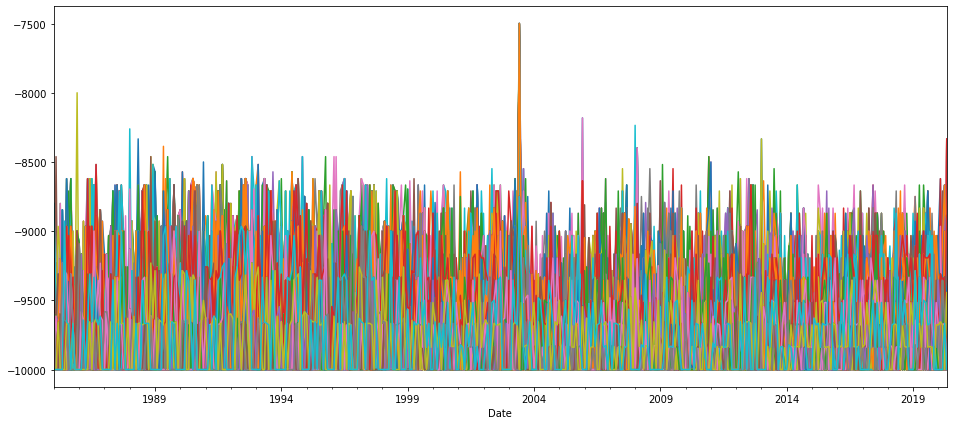

In [ ]:
ndvi_df.plot(figsize=(16,7), legend=False)

## load harmonic ndvi

In [ ]:
harm_df = pd.read_csv('data_files/processed_harm_ndvi.csv', parse_dates=True)
harm_df.index = pd.to_datetime(harm_df.iloc[:,0], format='%Y-%m-%d') 
harm_df = harm_df.iloc[:,1:]
harm_df.index.name = 'Date'

#full years only
harm_df = harm_df.loc[(harm_df.index > '1986') & (harm_df.index < '2020')]

harm_df.head()

,FMMOL,E12,ELFI,BBOB,VERMTL,CAN,befa,TZEI,GERM210,FELSM,CRO,UK67,OGEW,FSGW,FOU,SWIT259,VERM11,UK99,OSDS,Kom,SERR15,WESC,TOC,BOS_PER,OeS,OR2,Sinca3,OSSA06,CRO_CUD,MBA,E17,UK62,SZBH,CLFS,Sinca6,KNJB,E07,DRFS,QPOM,Gks,...,SHTS,CRO_RAM,RIED,DOFS,MSC,LR3,M04,MWSB,E09,PENNA,CEB,E39,UK10,FPTRE2,FSSW,QGHC,GERM206,DK1014,ROM_SEB,KAMP,M27,mos,SLO_SUT,HSKM,MON1,PIOV,NGMW,PWTS,FS30,s121,BALD,Runcu2,Z1,ITAL037,AGNE,LE50,NGLS,AFO,M11,BB
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1986-01-31,0.588699,0.532026,-0.117098,0.261137,-0.106084,0.195253,0.385088,-0.053554,0.539252,0.175342,0.281760,0.129390,-0.023868,0.565244,0.536370,-0.015052,0.401894,0.328261,0.102050,0.623523,0.401523,0.662059,0.496613,0.595116,0.682529,-0.012000,0.346003,0.241364,0.792553,0.304651,0.256432,0.667815,0.461104,0.252426,0.482364,0.675806,0.400853,0.497374,0.150064,0.505505,...,0.624156,0.759213,0.509677,0.790643,0.449974,0.572477,0.414582,0.638375,0.487695,0.759517,0.544454,0.249647,0.279786,0.405226,0.318868,0.403744,0.683440,0.711980,0.780428,0.472334,0.625440,0.663763,0.255201,0.588158,0.364799,0.617671,0.089124,0.106188,0.683394,0.392504,0.601957,0.442854,0.536782,0.277185,0.770591,0.436001,0.000922,0.476973,0.702265,0.399661
1986-02-28,0.554890,0.457753,0.007323,0.321345,0.015089,0.258110,0.379697,-0.063945,0.483418,0.223198,0.313686,0.113259,0.069031,0.562188,0.565291,0.151749,0.388719,0.138581,0.007619,0.600863,0.382496,0.659720,0.404516,0.583059,0.676510,-0.036839,0.336819,0.337653,0.796227,0.316285,0.173154,0.689458,0.394655,0.217054,0.472183,0.643122,0.399247,0.431509,0.012488,0.481699,...,0.627678,0.758698,0.522640,0.794796,0.408326,0.624847,0.424374,0.612923,0.432580,0.776336,0.503469,0.239058,0.296808,0.440045,0.379310,0.363100,0.672214,0.713632,0.781307,0.441170,0.664792,0.674327,0.006935,0.558765,0.316708,0.610609,-0.045802,0.102431,0.717420,0.309421,0.612397,0.456885,0.505272,0.305149,0.774930,0.503290,-0.123177,0.192814,0.728536,0.336341
1986-03-31,0.521082,0.383480,0.137212,0.381553,0.136262,0.320967,0.374306,0.190980,0.369832,0.271054,0.345612,0.097127,0.189324,0.559132,0.594211,0.318550,0.375544,0.276540,0.179150,0.578203,0.363469,0.657381,0.312419,0.571002,0.670491,-0.061677,0.327635,0.433942,0.799901,0.327920,0.384636,0.711101,0.328205,0.181681,0.462002,0.610438,0.397641,0.365643,0.161717,0.457892,...,0.631201,0.758183,0.535603,0.798949,0.366679,0.677217,0.434167,0.587471,0.377465,0.793155,0.462483,0.228470,0.373729,0.474864,0.491146,0.322456,0.660987,0.715284,0.782187,0.410006,0.704144,0.684891,0.172465,0.529373,0.446663,0.603547,0.108988,0.098675,0.751445,0.226337,0.622837,0.470915,0.473762,0.333112,0.779268,0.570578,-0.093596,0.296651,0.754806,0.273021
1986-04-30,0.611562,0.457194,0.347790,0.441762,0.257435,0.383823,0.618736,0.351527,0.256246,0.318911,0.377537,0.080996,0.309618,0.556076,0.623131,0.485351,0.362369,0.414498,0.350682,0.467087,0.344442,0.655042,0.427420,0.655196,0.664472,0.028713,0.318450,0.530231,0.803574,0.339554,0.596118,0.732744,0.460783,0.146309,0.451820,0.577754,0.396035,0.299778,0.310945,0.434086,...,0.634724,0.757668,0.548566,0.803102,0.508223,0.729587,0.443959,0.562019,0.465331,0.809975,0.421498,0.440522,0.450651,0.509684,0.602981,0.502128,0.649760,0.716936,0.783066,0.378842,0.743496,0.695455,0.337995,0.499981,0.576618,0.596485,0.263777,0.115137,0.785471,0.357857,0.633277,0.484946,0.442252,0.505279,0.783607,0.637867,0.073822,0.400489,0.781077,0.375902
1986-05-31,0.754400,0.530909,0.558369,0.501970,0.378609,0.446680,0.863166,0.512075,0.728913,0.366767,0.704559,0.064864,0.429911,0.553019,0.670218,0.652151,0.762470,0.552457,0.522213,0.711666,0.569144,0.652703,0.542421,0.739389,0.658453,0.119103,0.694756,0.769430,0.807248,0.515376,0.807600,0.754387,0.593361,0.769488,0.763666,0.545070,0.394429,0.779172,0.460174,0.758588,...,0.638246,0.757153,0.561529,0.807256,0.649768,0.781957,0.453752,0.536567,0.553197,0.826794,0.633318,0.652574,0.527572,0.418655,0.714817,0.624442,0.638534,0.71858

#### visualize harmonized data

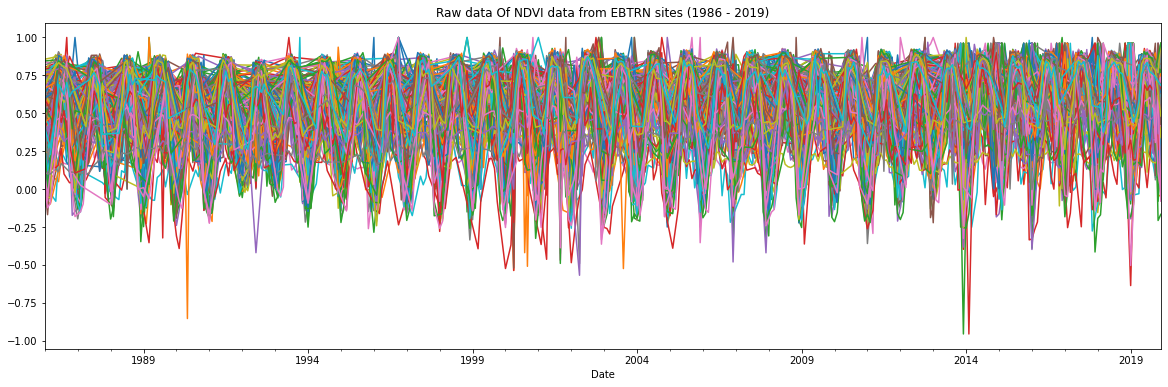

In [ ]:
harm_df.plot(figsize=(20,6), legend=False, title='Raw data Of NDVI data from EBTRN sites (1986 - 2019)')

In [ ]:
harm_df.mean().mean()

0.6041431286170594

# computing components from actual Harmonized dataset to create the synthtic data

In [ ]:
def get_mean_and_std(df, y_label='Data Unit', title='title'):
  fig, ax = plt.subplots()

  mean_df = df.T.mean()
  mean_df.plot(ax=ax, label='mean')

  std_df = df.T.std()
  #std_ndvi.plot(ax=ax)

  ax.fill_between(mean_df.index, std_df + mean_df, mean_df - std_df, alpha=0.2, label='std')


  ax.set_ylabel(y_label)
  ax.set_xlabel('Date')
  ax.set_title(title)
  fig.set_size_inches(16,8)
  plt.legend()
  return mean_df

def get_component_df(df, trend='STL', ts_length=None):
  '''
    input_params: 
      df: input the dataframe of which the trends are to be extracted from
          requirements for the dataframe:
          - dataframe index need to be datetime,
          - datetime index should be sorted
          - should be a monthly resampling
  '''
  trend_dict = {}
  seas_dict = {}

  if trend == 'STL':
    yr_list = df.index.year
    seasons = yr_list[-1] - yr_list[0]
    if seasons % 2 == 0:
      seasons += 1

    for col in df:
      stl = STL(df[col], period=12, seasonal=seasons, robust=True)
      res = stl.fit()
      #print(res.trend)
      trend_dict[col] = res.trend
      seas_dict[col] = res.seasonal

  output_dict = {'trend': pd.DataFrame(trend_dict),
                 'seasons': pd.DataFrame(seas_dict)}
  return output_dict

In [ ]:
output_dict = get_component_df(harm_df,'STL')
trend_df = output_dict['trend']
season_df = output_dict['seasons']

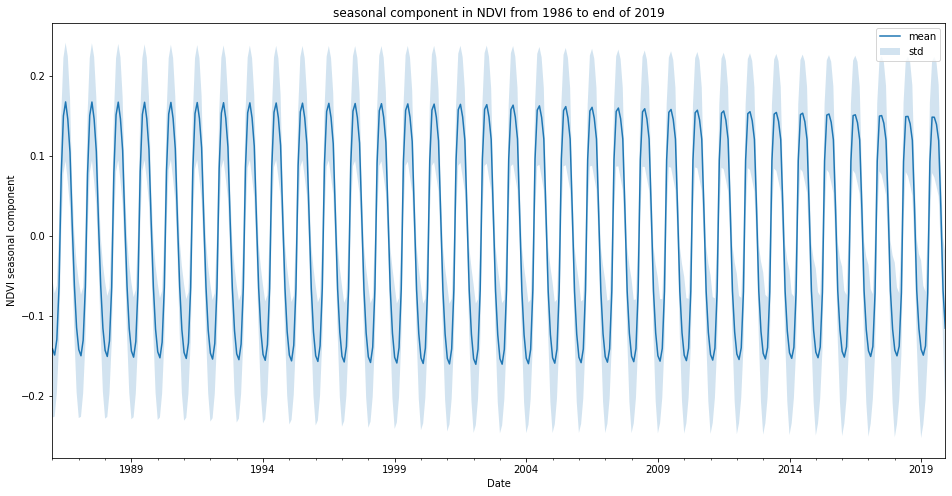

In [ ]:
harm_mean = get_mean_and_std(season_df, 'NDVI seasonal component', 'seasonal component in NDVI from 1986 to end of 2019')

# synthetic signal creation

### getting parameters for the synthetic signal creation

-1.0303030303030303
0.16411883597423046
0


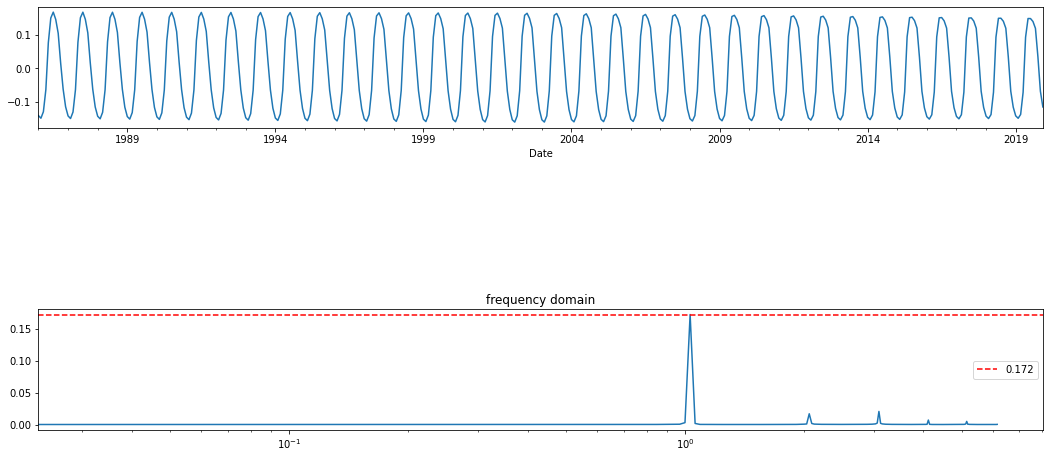

In [ ]:
#https://stackoverflow.com/questions/51298604/calculating-amplitude-from-np-fft

fig, axes = plt.subplots(nrows=2,ncols=1)
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5, wspace=0.4)

harm_mean.plot(figsize=(18,6), ax=axes[0])

#ys = 7 * np.sin(15 * 2 * np.pi * xs)


np_fft = np.fft.fft(harm_mean)
amplitudes = 2 / len(harm_mean) * np.abs(np_fft)
#amplitudes = np.abs(np_fft)
yr_list = harm_mean.index.year
seasons = yr_list[-1] - yr_list[0]

frequencies = np.fft.fftfreq( len(harm_mean) ) * len(harm_mean) / seasons#( max(harm_mean) - min(harm_mean) )

match_freq = 0

# for idx, val in enumerate(frequencies):
#   if val != 0:
#     print(val)

for idx, val in enumerate(amplitudes):
  if max(amplitudes) == val:
    print(frequencies[idx])

axes[1].semilogx(frequencies[:len(frequencies) // 2], amplitudes[:len(np_fft) // 2])
axes[1].axhline(max(amplitudes), c='r', ls='--', label=str( round( max(amplitudes),3 )))
axes[1].legend(loc='best')
axes[1].set_title('frequency domain')
#print(max(amplitudes))
print((max(harm_mean) - min(harm_mean))/2)
print(match_freq)

## modelling signal

amp: 0.17191412238897777 ≈ 0.172 
freq: 13.08991953813964 ≈ 13.09 
phase: 0.34650944562911457 ≈ 0.347 
offset: 5.820600323469885e-07 ≈ 0.0


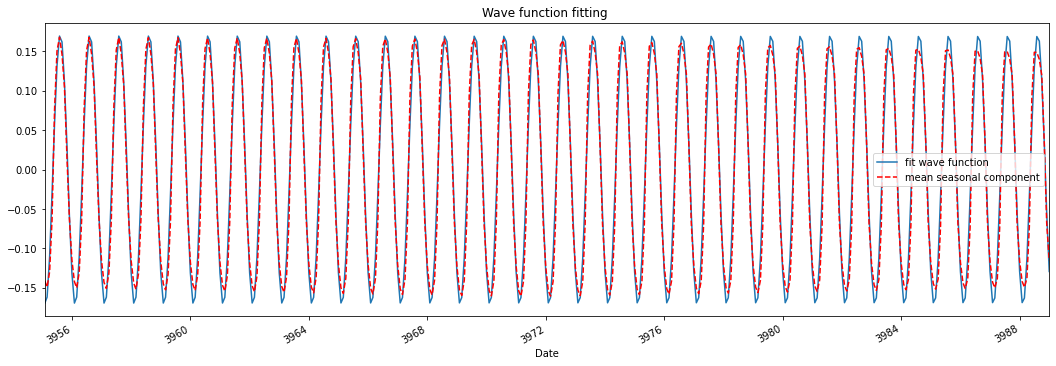

In [ ]:
from scipy.optimize import curve_fit
#mport matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (18,6)

def wav_fn(x, amplitude, freq, phase, offset):
  #https://www.mathsisfun.com/algebra/amplitude-period-frequency-phase-shift.html
  return amplitude * np.sin(freq * (x + phase)) + offset



    
def calc_wave(input_x, input_y, p0):
    params, covariance = curve_fit(wav_fn, input_x, input_y, p0)
    wave = wav_fn(input_x, *params)
    return(wave,params)

np.random.seed(1)
p0 = [0.1717022, 13.0899, -0.0017, 6]
wave,params = calc_wave(range(0,len(harm_mean)), harm_mean, p0)

p1 = [0.172, -1.03, -0.005, 0]
wave2, params2 = calc_wave(range(0,len(harm_mean)), harm_mean, p1)

wave2 = [wav_fn(idx, params[0], params[1], params[2], 0.6) for idx, x in enumerate(harm_mean)]

fig, ax = plt.subplots()
#ax.plot(harm_mean.index, wave2, ls='-.')
ax.plot(harm_mean.index,wave , label='fit wave function')
harm_mean.plot(ax=ax, c='r', ls='--', label='mean seasonal component')
ax.set_title('Wave function fitting ')
ax.legend()
print('amp:', params[0],  '\u2248 ' + str(round(params[0], 3)),
      '\nfreq:',params[1],  '\u2248 ' + str(round(params[1], 3)),
      '\nphase:',params[2],  '\u2248 ' + str(round(params[2], 3)),
      '\noffset:',params[3], '\u2248 ' + str(round(params[3], 3)))

# if i want to use the offset

# fig, ax = plt.subplots()
# ax.plot(harm_mean.index, wave2, ls='-.')
# ax.plot(harm_mean.index,wave , label='fit wave function')
# harm_mean.plot(ax=ax, c='r', ls='--', label='mean seasonal component')
# ax.set_title('Wave function fitting ')
# ax.legend()
# print('amp:', params[0],  '\u2248 ' + str(round(params[0], 3)),
#       '\nfreq:',params[1],  '\u2248 ' + str(round(params[1], 3)),
#       '\nphase:',params[2],  '\u2248 ' + str(round(params[2], 3)),
#       '\noffset:',params[3], '\u2248 ' + str(round(params[3], 3)))

In [ ]:
outdir = 'synthetic_component'
if not os.path.exists(outdir):
    os.mkdir(outdir)

wave_df = pd.DataFrame({ 'date': harm_df.index, 
               'wave': wave }).set_index('date')
               
wave_df.to_csv('synthetic_component/wave.csv')

## read in synthetic seasonal component (need)

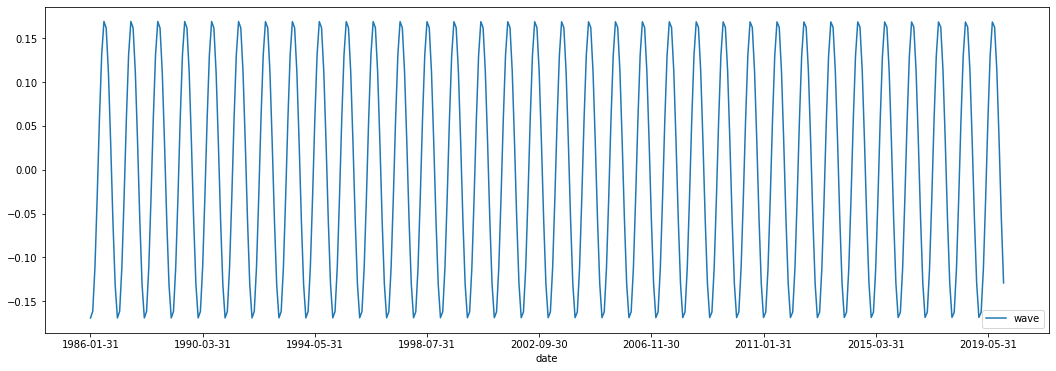

In [ ]:
season_comp = pd.read_csv('synthetic_component/wave.csv', index_col='date')
season_comp.plot()

In [ ]:
len(season_comp)

408

## protyping functions for trend creation

[ 0.   -0.1  -0.2  -0.3  -0.29 -0.39 -0.49 -0.59 -0.69 -0.79]
[0 0 0 0 5 5 5 5 5 5]


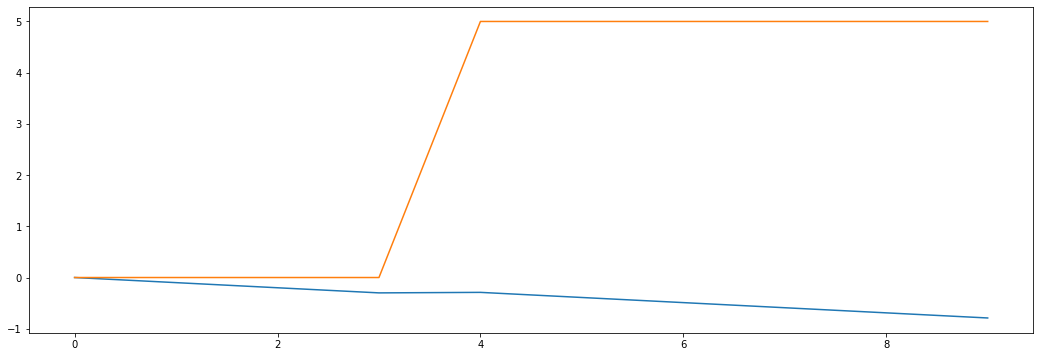

In [ ]:

import matplotlib.pyplot as plt

# trend_config = {breakpoints:
#                 gradients:
#                 steps:}

# season_config = {amp:
#                  freq:
#                  phase:
#                  offset:}

# resid_config = {mean:
#                 min:
#                 max:
#                 std:
#                 }

breakpoint_list = [(0,4,1,0),(4,10,-1,5)]

def create_trend(n, breakpoints_list):
  trend = [0] * n 
  start_point = None
  for start, end, gradient, offset in breakpoints_list:
    #trend.append(offset)
    for x in range(start, end):
      if x == start:
        if x == 0:
          trend[x] = offset
        else:
          #print(trend[x],'add:', offset)
          trend[x] = offset + trend[x-1]
      else:
        trend[x] += gradient * (x - (x-1)) + trend[x-1] 
        
      
  return np.array(trend)

def create_residuals(n, mean, std):
  # assuming completeness of the residuals, 
  # assumption is that the residuals will take on a gaussian distribution
  seed(1)
  return [gauss(mean, std) for x in range(n)]

def create_season(n):
  signal = pd.read_csv('synthetic_component/wave.csv', index_col='date')
  return np.array(signal['wave'])[:n]

breakpoint_list = [(0,4,-0.1,0),(4,10,-0.1,.01)]
trend = create_trend(10, breakpoint_list)
print(trend)
plt.plot(trend)


breakpoint_list = [(0,4,0,0),(4,10,0,5)]
trend = create_trend(10, breakpoint_list)
print(trend)
plt.plot(trend)

residuals = create_residuals(5,0, 0.08)  

## create synthetic signal dataset(need)

0
-0.002
-0.001
0
-0.001
-0.0005
0
-0.0002
-0.0001
0
-0.0001
-5e-05
0
-2e-05
-1e-05


,signal,breakpoints,residuals
0,"[0.5338153190948669, 0.5542852089790662, 0.494...","[(0, 200, 0, 0.6), (200, 300, -0.002, 0), (300...","[0, 0.08]"
1,"[0.5338153190948669, 0.5542852089790662, 0.494...","[(0, 200, 0, 0.6), (200, 300, -0.001, 0), (300...","[0, 0.08]"
2,"[0.5338153190948669, 0.5542852089790662, 0.494...","[(0, 200, 0, 0.6), (200, 300, -0.0002, 0), (30...","[0, 0.08]"
3,"[0.5338153190948669, 0.5542852089790662, 0.494...","[(0, 200, 0, 0.6), (200, 300, -0.0001, 0), (30...","[0, 0.08]"
4,"[0.5338153190948669, 0.5542852089790662, 0.494...","[(0, 200, 0, 0.6), (200, 300, -2e-05, 0), (300...","[0, 0.08]"


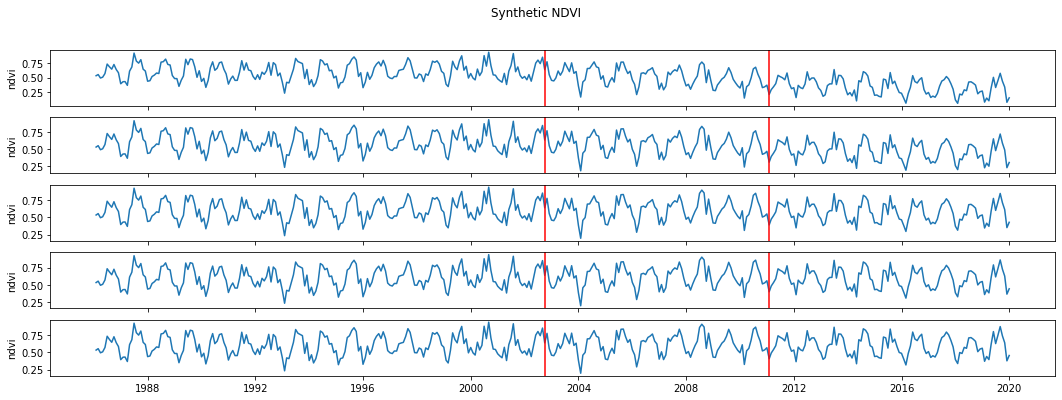

In [ ]:
breakpoint_list = [(0,200,0,0.6),(200,300,-0.002,0),(300,408,-0.001,0)]
residuals_config = [0, 0.03]


def create_synthetic_signal(breakpoint_list, residuals_config):
  no_points = breakpoint_list[-1][1]
  print(no_points)

  trend = create_trend(no_points, breakpoint_list)
  season = create_season(no_points)
  residuals = create_residuals(no_points,0, 0.03) 

  fig, ax = plt.subplots()
  ax.plot(trend)
  # print(len(season))
  # print(len(residuals))

  fake_signal = season+trend+residuals

  fake_signal[fake_signal < 0] = 0

  return fake_signal

class SynthSignal:
  def __init__(self, breakpoint_list, residuals_config):
    self.breakpoint_list = breakpoint_list
    self.residuals_config = residuals_config
    self.residual_mean = residuals_config[0]
    self.residual_std = residuals_config[1]
    self.no_points = self.breakpoint_list[-1][1]
    self.signal = self.create_synthetic_signal()
    self.df = self.create_df()
    

  def create_trend(self, n, breakpoints_list):
    trend = [0] * n 
    start_point = None
    for start, end, gradient, offset in breakpoints_list:
      print(gradient)
      #trend.append(offset)
      for x in range(start, end):
        if x == start:
          if x == 0:
            trend[x] = offset
          else:
            #print(trend[x],'add:', offset)
            trend[x] = offset + trend[x-1]
        else:
          trend[x] += gradient * (x - (x-1)) + trend[x-1] 
          
        
    return np.array(trend)

  def create_residuals(self, n, mean, std):
    # assuming completeness of the residuals, 
    # assumption is that the residuals will take on a gaussian distribution
    seed(1)
    return [gauss(mean, std) for x in range(n)]

  def create_season(self, n):
    signal = pd.read_csv('synthetic_component/wave.csv', index_col='date')
    return np.array(signal['wave'])[:n]

  def create_synthetic_signal(self):
    # returns np.array signal
    trend = self.create_trend(self.no_points, self.breakpoint_list)
    season = self.create_season(self.no_points)
    residuals = self.create_residuals(self.no_points, self.residual_mean,
                                 self.residual_std) 
    

    fake_signal = season+trend+residuals

    fake_signal[fake_signal < 0] = 0

    return fake_signal

  

  def create_df(self):
    syn_signal_df = pd.DataFrame({'signal': [self.signal],
                              'breakpoints': [self.breakpoint_list],
                              'residuals': [self.residuals_config]})
    return syn_signal_df



signal_list = []
signal_df = {}

residual_std_list = [0.08]
grad_scaler_list = [0.001, 0.0005, 0.0001, 0.00005, 0.00001]
for std in residual_std_list:
  for grad_scaler in grad_scaler_list:
    residuals_config = [0, std]
    breakpoint_list = [(0,200,0,0.6),(200,300,-2 * grad_scaler, 0), (300,408,-1 * grad_scaler, 0)]
    fake_signal_1 = SynthSignal(breakpoint_list, residuals_config)
    signal_list.append(fake_signal_1)
    if len(signal_df) == 0:
      signal_df = fake_signal_1.df
    else:
      signal_df = signal_df.append(fake_signal_1.df)

signal_df = signal_df.reset_index().iloc[:,1:]

fig, ax = plt.subplots(len(signal_df.index),1, sharex=True)
for idx, row in signal_df.iterrows():
  ax[idx].plot(harm_df.index, row['signal'])
  ax[idx].set_ylabel('ndvi')
  for bp_idx, bp_params in enumerate(row['breakpoints']):
    if bp_idx != 0:
      ax[idx].axvline(harm_df.index[bp_params[0]], c='r')
fig.suptitle('Synthetic NDVI')
# fig, ax = plt.subplots(len(signal_list),1, sharex=True)
# for idx, signal in enumerate(signal_list):
#   ax[idx].plot(harm_df.index, signal_list[idx].signal)
display(signal_df)

### writing the sythetic signal to drive

##### makes folder if emtpy

In [ ]:
import os
if not os.path.exists('synthetic_signals'):
    os.makedirs('synthetic_signals')

##### write the dataframe to folder

In [ ]:
signal_df.to_csv('synthetic_signals/signal_df.csv')

In [ ]:
df = pd.DataFrame()
for idx, row in enumerate(signal_df['signal']):
  if idx == 0:
    df[idx] = row
  else:
    df[idx] = row
df.index = harm_df.index
df

,0,1,2,3,4
Date,,,,,
1986-01-31,0.533815,0.533815,0.533815,0.533815,0.533815
1986-02-28,0.554285,0.554285,0.554285,0.554285,0.554285
1986-03-31,0.494517,0.494517,0.494517,0.494517,0.494517
1986-04-30,0.508608,0.508608,0.508608,0.508608,0.508608
1986-05-31,0.571057,0.571057,0.571057,0.571057,0.571057
...,...,...,...,...,...
2019-08-31,0.575722,0.726222,0.846622,0.861672,0.873712
2019-09-30,0.440827,0.591827,0.712627,0.727727,0.739807
2019-10-31,0.339808,0.491308,0.612508,0.627658,0.639778


In [ ]:
df.to_csv('synthetic_signals/signals_df.csv')

In [ ]:
signal_df['breakpoints']

0    [(0, 200, 0, 0.6), (200, 300, -0.002, 0), (300...
1    [(0, 200, 0, 0.6), (200, 300, -0.001, 0), (300...
2    [(0, 200, 0, 0.6), (200, 300, -0.0002, 0), (30...
3    [(0, 200, 0, 0.6), (200, 300, -0.0001, 0), (30...
4    [(0, 200, 0, 0.6), (200, 300, -2e-05, 0), (300...
Name: breakpoints, dtype: object

#### check distribution of the synthetic parts 

In [ ]:
seasons = harm_df.index.year[-1] - harm_df.index.year[0] 
seasons

33

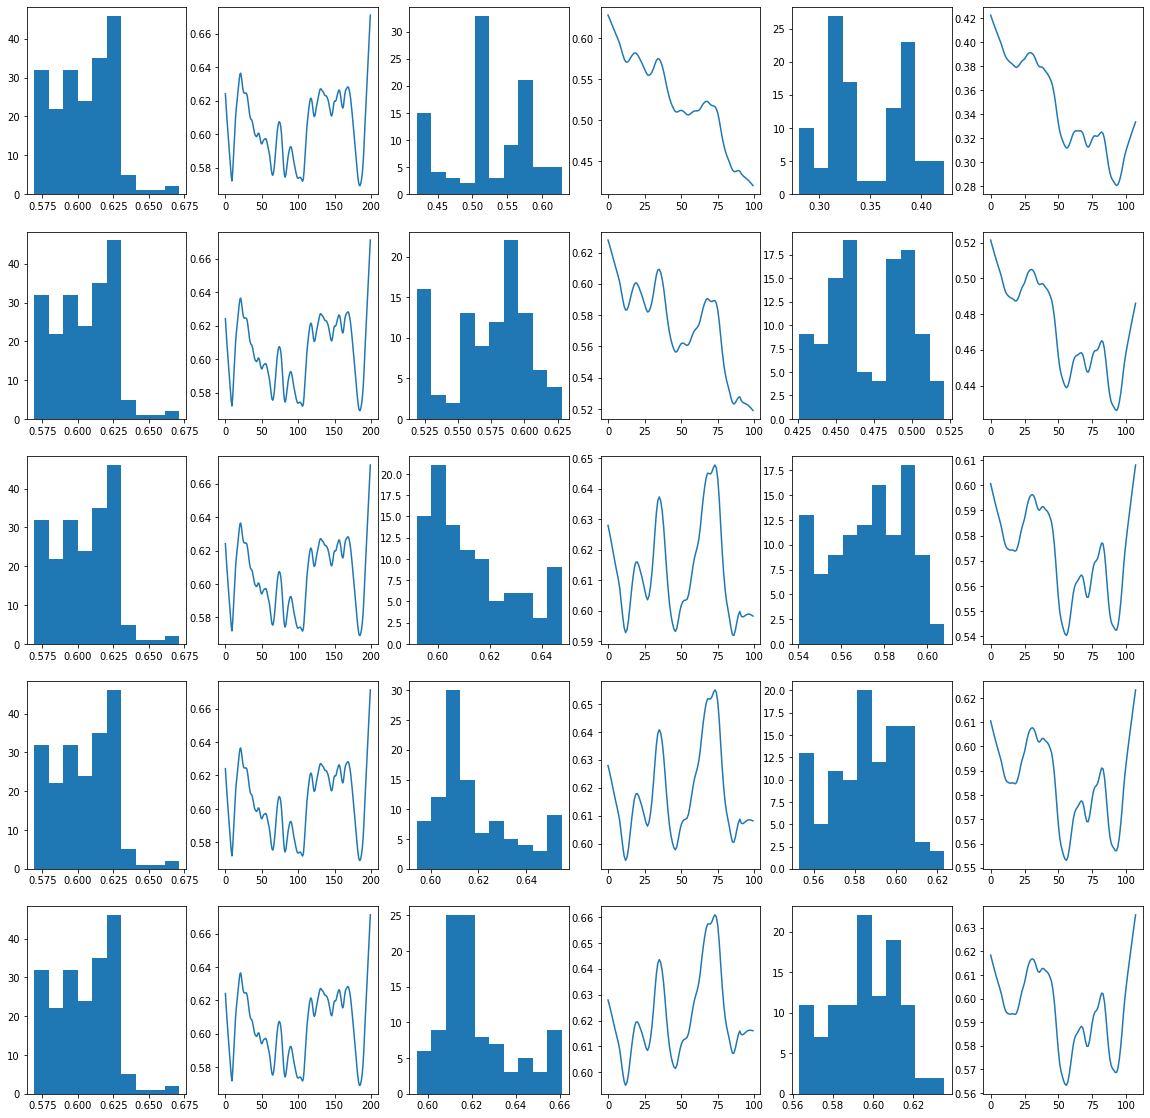

In [ ]:
# get the distributions of the trend 
fig, ax = plt.subplots(len(signal_df), 6, figsize=(20,20))
for idx, row in signal_df.iterrows():
  for bp_idx, breakpoint in enumerate(row['breakpoints']):
    stl = STL(row['signal'][breakpoint[0] : breakpoint[1]], period=12, seasonal=33, robust=True)
    res = stl.fit()
    trend = res.trend
    ax[idx, bp_idx*2+1].plot(trend)
    ax[idx, bp_idx*2].hist(trend)

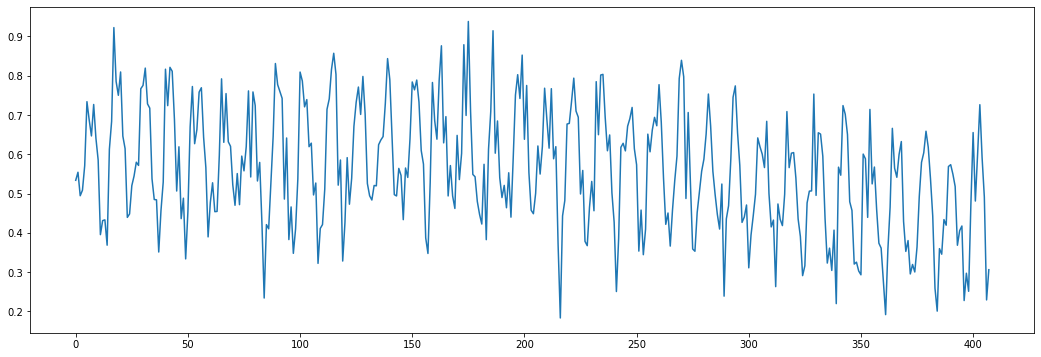

In [ ]:
plt.plot(signal_df['signal'][1])

In [ ]:
for idx, row in signal_df.iterrows():
  row['signal']

## testing STL + BCPD

In [ ]:
def extract_climate_trend(df, trend='STL'):
  '''
    input_params: 
      df: input the dataframe of which the trends are to be extracted from
          requirements for the dataframe:
          - dataframe index need to be datetime,
          - datetime index should be sorted
          - should be a monthly resampling
  '''
  climate_trend_df = pd.DataFrame()

  if trend == 'STL':
    yr_list = df.index.year
    #print(yr_list[-1])
    #print(yr_list[0])
    seasons = yr_list[-1] - yr_list[0]

    if seasons % 2 == 0:
      seasons += 1
    

    for col in df:
      stl = STL(df[col], period=12, seasonal=seasons, robust=True)
      res = stl.fit()
      #print(res.trend)
      climate_trend_df[col] = res.trend
      
  return climate_trend_df

def get_change_points(df, detector):
  date_list = []
  for idx, row in detector.change_points['traj_0'].iterrows():
    date_list.append(df.index[row['ts']])
  return date_list

segmentation papaper : https://arxiv.org/pdf/1101.1438.pdf

In [ ]:
dates = harm_df.index

def linear_penalty(signal, b=0.045):
  return len(signal) * b

def bic_penalty(signal, std=0.08):
  '''AICl2
  '''
  return float(len(signal) * np.log(len(signal)) * (np.std(signal)**2))

def aic_penalty(signal, std=0.08):
  '''AICl2
  '''
  return float(len(signal) * (np.std(signal)**2))

def get_decomp_plus_cp(signal, dates, decomp_algo='STL', cp_algo='bayes', config=None):
  #formatting the np.array to dataframe for trend extraction
  signal = pd.DataFrame({'signal': signal})
  signal.index = dates


  #trend extraction
  if config:
    if 'decomp_algo' in config:
      decomp_algo = config['decomp_algo']
  if decomp_algo == 'STL':
    signal_trend = extract_climate_trend(signal, 'STL')
    signal = np.array(signal_trend['signal'])

  if decomp_algo == None:
    signal = np.array(signal)

  #change point detection

  #bayesian change point detection
  if cp_algo == 'bayes':
  #change point detection
    
    #assign config if exists
    if config:
      if 'distribution' in config:
        distribution = config['distribution']
      if 'log_odds_threshold' in config:
        log_odds = config['log_odds_threshold']
      detector = cpDetector([signal], distribution=distribution, log_odds_threshold=log_odds)
    #else use log normal and 0 treshold
    else:
      detector = cpDetector([signal], distribution='log_normal', log_odds_threshold=0)
    detector.detect_cp()
    
    
    #gets the breakpoints via idx from the detector
    predicted_breaks = detector.change_points['traj_0']['ts'].values

  pen = bic_penalty(signal)

  if cp_algo == 'pelt':
    model = 'rbf'
    #pen= 10
    if config:
      if 'model' in config:
        model = config['model']
      if 'pen' in config:
        pen = config['pen']
    algo = rpt.Pelt(model=model).fit(signal)
    #gets the breakpoints via idx from the detector
    predicted_breaks = algo.predict(pen=pen) #may need to change the 10


  if cp_algo == 'binseg':
    algo = rpt.Binseg(model='rbf').fit(signal)
    predicted_breaks = algo.predict(pen=pen)

  if cp_algo == 'window':
    width = 10
    model = 'rbf'
    std = 0.045
    #cost = rpt.costs.CostRank().fit(signal)
    if config:
      if 'width' in config:
        width = config['width']
      if 'model' in config:
        model = config['model']
      if 'std' in config:
        std = config['std']
    n_bkps = 3*len(signal)*std**2

    algo = rpt.Window(width=width).fit(signal)
    predicted_breaks = algo.predict(pen=pen)

  return predicted_breaks

def get_bp_from_list(breakpoint_list):
  bp_list = []
  for idx, bp in enumerate(breakpoint_list):
    if idx >= 1:
      bp_list.append(bp[0])

    if idx+1 == len(breakpoint_list):
      bp_list.append(bp[1])
  return bp_list


algo_list = [ #('bayes', {'decomp_algo': None,'distribution': 'log_normal', 'log_odds_threshold':0}),
             #('bayes', {'decomp_algo': None,'distribution': 'log_normal', 'log_odds_threshold':25}),
             #('bayes', {'decomp_algo': None,'distribution': 'log_normal', 'log_odds_threshold':50}),
             #('bayes', {'decomp_algo': 'STL','distribution': 'log_normal', 'log_odds_threshold':0}),
             #('bayes', {'decomp_algo': 'STL','distribution': 'log_normal', 'log_odds_threshold':25}),
             #('bayes', {'decomp_algo': 'STL','distribution': 'log_normal', 'log_odds_threshold':50}), 
             ('bayes', {'decomp_algo': None,'distribution': 'normal', 'log_odds_threshold':0}),
             ('bayes', {'decomp_algo': None,'distribution': 'normal', 'log_odds_threshold':25}),
             ('bayes', {'decomp_algo': None,'distribution': 'normal', 'log_odds_threshold':50}),
             ('bayes', {'decomp_algo': 'STL','distribution': 'normal', 'log_odds_threshold':0}),
             ('bayes', {'decomp_algo': 'STL','distribution': 'normal', 'log_odds_threshold':25}),
             ('bayes', {'decomp_algo': 'STL','distribution': 'normal', 'log_odds_threshold':50}),
             ('pelt' , {'decomp_algo': 'STL'}),
             ('pelt' , {'decomp_algo': None}),
             ('binseg', {'decomp_algo': 'STL'}),
             ('binseg', {'decomp_algo': None}),
             ('window', {'decomp_algo': None, 'width':10}),
             ('window', {'decomp_algo': None, 'width':20}),
             ('window', {'decomp_algo': None, 'width':30}),
             ('window', {'decomp_algo': 'STL','width':10}),
             ('window', {'decomp_algo': 'STL','width':20}),
             ('window', {'decomp_algo': 'STL','width':30}),
             ('window', {'decomp_algo': None,'std': 0.3,'width':10}),
             ('window', {'decomp_algo': None,'std': 0.3, 'width':20}),
             ('window', {'decomp_algo': None,'std': 0.3, 'width':30})]





cp_df = {}




# display(signal_df.iloc[1,:])
for idx, row in signal_df.iterrows():
  bp_list = get_bp_from_list(row['breakpoints'])

  

  for algo_info in algo_list:
    algo = algo_info[0]
    h_score = None
    rand_score = None
    recall_score = (None, None)
    f1_score = None
    #print(algo[1])
    bp = get_decomp_plus_cp(row['signal'], dates, cp_algo=algo, config=algo_info[1])
    
    signal_length = len(row['signal']) #cardinality


    
    #fotmatting the breakpoints for scoring functions
    if algo == 'bayes':
      
      if len(bp) > 0:
        bp = np.append(bp ,signal_length)
        h_score = hausdorff(bp, bp_list)
        rand_score = randindex(bp, bp_list)
        recall_score = precision_recall(bp, bp_list)
      else:
        bp = [signal_length]

        

    elif algo in ['pelt','binseg', 'window']:
      if len(bp) > 1:
        h_score = hausdorff(bp, bp_list)
        rand_score = randindex(bp, bp_list)
        recall_score = precision_recall(bp, bp_list)
    
    if recall_score != (None, None):
      if recall_score[0] != 0 and recall_score[1] != 0:
        f1_score = 2 * (recall_score[0] * recall_score[1]) / (recall_score[0] + recall_score[1])

    if len(cp_df) < 1:
      row['signal_no'] = idx
      row['ann_err'] = len(bp) - len(bp_list)
      row['hausdorff'] = h_score
      row['randindex'] = rand_score
      row['precision'] = recall_score[0]
      row['recall'] = recall_score[1]
      row['f1_score'] = f1_score
      row['algo'] = algo
      row['params'] = algo_info[1]
      row['decomp'] = algo_info[1]['decomp_algo']
      row['pred_bp'] = bp
      cp_df = pd.DataFrame(row).T
      
    else:
      row['signal_no'] = idx
      row['ann_err'] = len(bp) - len(bp_list)
      row['hausdorff'] = h_score
      row['randindex'] = rand_score
      row['precision'] = recall_score[0]
      row['recall'] = recall_score[1]
      row['f1_score'] = f1_score
      row['algo'] = algo
      row['params'] = algo_info[1]
      row['decomp'] = algo_info[1]['decomp_algo']
      row['pred_bp'] = bp
      cp_df = cp_df.append(row, ignore_index=True)


display(cp_df)   

print(cp_df['hausdorff'].mean())

,signal,breakpoints,residuals,signal_no,ann_err,hausdorff,randindex,precision,recall,f1_score,algo,params,decomp,pred_bp
0,"[0.5338153190948669, 0.5542852089790662, 0.494...","[(0, 200, 0, 0.6), (200, 300, -0.002, 0), (300...","[0, 0.08]",0,-1,74,0.671605,0,0,None,bayes,"{'decomp_algo': None, 'distribution': 'normal'...",None,"[274, 408]"
1,"[0.5338153190948669, 0.5542852089790662, 0.494...","[(0, 200, 0, 0.6), (200, 300, -0.002, 0), (300...","[0, 0.08]",0,-1,74,0.671605,0,0,None,bayes,"{'decomp_algo': None, 'distribution': 'normal'...",None,"[274, 408]"
2,"[0.5338153190948669, 0.5542852089790662, 0.494...","[(0, 200, 0, 0.6), (200, 300, -0.002, 0), (300...","[0, 0.08]",0,-2,None,None,None,None,None,bayes,"{'decomp_algo': None, 'distribution': 'normal'...",None,[408]
3,"[0.5338153190948669, 0.5542852089790662, 0.494...","[(0, 200, 0, 0.6), (200, 300, -0.002, 0), (300...","[0, 0.08]",0,3,85,0.673647,0.5,0.2,0.285714,bayes,"{'decomp_algo': 'STL', 'distribution': 'normal...",STL,"[240, 279, 351, 307, 385, 408]"
4,"[0.5338153190948669, 0.5542852089790662, 0.494...","[(0, 200, 0, 0.6), (200, 300, -0.002, 0), (300...","[0, 0.08]",0,1,51,0.665069,0,0,None,bayes,"{'decomp_algo': 'STL', 'distribution': 'normal...",STL,"[240, 279, 351, 408]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,"[0.5338153190948669, 0.5542852089790662, 0.494...","[(0, 200, 0, 0.6), (200, 300, -2e-05, 0), (300...","[0, 0.08]",4,-2,None,None,None,None,None,window,"{'decomp_algo': 'STL', 'width': 20}",STL,[408]
91,"[0.5338153190948669, 0.5542852089790662, 0.494...","[(0, 200, 0, 0.6), (200, 300, -2e-05, 0), (300...","[0, 0.08]",4,-2,None,None,None,None,None,window,"{'decomp_algo': 'STL', 'width': 30}",STL,[408]
92,"[0.5338153190948669, 0.5542852089790662, 0.494...","[(0, 200, 0, 0.6), (200, 300, -2e-05, 0), (300...","[0, 0.08]",4,-2,None,None,None,None,None,window,"{'decomp_algo': None, 'std': 0.3, 'width': 10}",None,[408]
93,"[0.5338153190948669, 0.5542852089790662, 0.494...","[(0, 200, 0, 0.6), (200, 300, -2e-05, 0), (300...","[0, 0.08]",4,-2,None,None,None,None,None,window,"{'decomp_algo': None, 'std': 0.3, 'width': 20}",None,[408]


110.42857142857143


###### STL + algo default scores

In [ ]:
for algo in cp_df['algo'].unique():
  for decomp in cp_df['decomp'].unique():
    for metric in ['ann_err', 'hausdorff', 'randindex', 'precision','recall', 'f1_score']:
      print(algo,' \t w decomp style:',decomp,' ',metric,'\t\tmean: ',cp_df[ (cp_df['algo'] == algo) & (cp_df['decomp'] == decomp)][metric].mean())

bayes  	 w decomp style: None   ann_err 		mean:  nan
bayes  	 w decomp style: None   hausdorff 		mean:  nan
bayes  	 w decomp style: None   randindex 		mean:  nan
bayes  	 w decomp style: None   precision 		mean:  nan
bayes  	 w decomp style: None   recall 		mean:  nan
bayes  	 w decomp style: None   f1_score 		mean:  nan
bayes  	 w decomp style: STL   ann_err 		mean:  -0.8333333333333334
bayes  	 w decomp style: STL   hausdorff 		mean:  93.0
bayes  	 w decomp style: STL   randindex 		mean:  0.6640248660017641
bayes  	 w decomp style: STL   precision 		mean:  0.058823529411764705
bayes  	 w decomp style: STL   recall 		mean:  0.023529411764705882
bayes  	 w decomp style: STL   f1_score 		mean:  0.28571428571428575
pelt  	 w decomp style: None   ann_err 		mean:  nan
pelt  	 w decomp style: None   hausdorff 		mean:  nan
pelt  	 w decomp style: None   randindex 		mean:  nan
pelt  	 w decomp style: None   precision 		mean:  nan
pelt  	 w decomp style: None   recall 		mean:  nan
pelt  	 w d

#### Bayes

###### -signal 1



In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    #no_none_cp_df = cp_df[cp_df.notnull().all(axis=1)]
    display(cp_df[(cp_df['signal_no'] == 0) & (cp_df['algo'] == 'bayes')][['pred_bp','decomp','params','ann_err']])

,pred_bp,decomp,params,ann_err
0,"[274, 408]",None,"{'decomp_algo': None, 'distribution': 'normal'...",-1
1,"[274, 408]",None,"{'decomp_algo': None, 'distribution': 'normal'...",-1
2,[408],None,"{'decomp_algo': None, 'distribution': 'normal'...",-2
3,"[240, 279, 351, 307, 385, 408]",STL,"{'decomp_algo': 'STL', 'distribution': 'normal...",3
4,"[240, 279, 351, 408]",STL,"{'decomp_algo': 'STL', 'distribution': 'normal...",1
5,"[240, 279, 408]",STL,"{'decomp_algo': 'STL', 'distribution': 'normal...",0


##### -signal 2

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    #no_none_cp_df = cp_df[cp_df.notnull().all(axis=1)]
    display(cp_df[(cp_df['signal_no'] == 1) & (cp_df['algo'] == 'bayes')][['pred_bp','decomp','params','ann_err']])

,pred_bp,decomp,params,ann_err
19,"[285, 408]",None,"{'decomp_algo': None, 'distribution': 'normal'...",-1
20,[408],None,"{'decomp_algo': None, 'distribution': 'normal'...",-2
21,[408],None,"{'decomp_algo': None, 'distribution': 'normal'...",-2
22,"[280, 350, 408]",STL,"{'decomp_algo': 'STL', 'distribution': 'normal...",0
23,"[280, 350, 408]",STL,"{'decomp_algo': 'STL', 'distribution': 'normal...",0
24,"[280, 408]",STL,"{'decomp_algo': 'STL', 'distribution': 'normal...",-1


##### signal 3

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    #no_none_cp_df = cp_df[cp_df.notnull().all(axis=1)]
    display(cp_df[(cp_df['signal_no'] == 2) & (cp_df['algo'] == 'bayes')][['pred_bp','decomp','params','ann_err']])

,pred_bp,decomp,params,ann_err
38,[408],None,"{'decomp_algo': None, 'distribution': 'normal'...",-2
39,[408],None,"{'decomp_algo': None, 'distribution': 'normal'...",-2
40,[408],None,"{'decomp_algo': None, 'distribution': 'normal'...",-2
41,"[350, 408]",STL,"{'decomp_algo': 'STL', 'distribution': 'normal...",-1
42,[408],STL,"{'decomp_algo': 'STL', 'distribution': 'normal...",-2
43,[408],STL,"{'decomp_algo': 'STL', 'distribution': 'normal...",-2


##### signal 4

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    #no_none_cp_df = cp_df[cp_df.notnull().all(axis=1)]
    display(cp_df[(cp_df['signal_no'] == 3) & (cp_df['algo'] == 'bayes')][['pred_bp','decomp','params','ann_err']])

,pred_bp,decomp,params,ann_err
57,[408],None,"{'decomp_algo': None, 'distribution': 'normal'...",-2
58,[408],None,"{'decomp_algo': None, 'distribution': 'normal'...",-2
59,[408],None,"{'decomp_algo': None, 'distribution': 'normal'...",-2
60,"[350, 408]",STL,"{'decomp_algo': 'STL', 'distribution': 'normal...",-1
61,[408],STL,"{'decomp_algo': 'STL', 'distribution': 'normal...",-2
62,[408],STL,"{'decomp_algo': 'STL', 'distribution': 'normal...",-2


##### signal 5

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    #no_none_cp_df = cp_df[cp_df.notnull().all(axis=1)]
    display(cp_df[(cp_df['signal_no'] == 4) & (cp_df['algo'] == 'bayes')][['pred_bp','decomp','params','ann_err']])

,pred_bp,decomp,params,ann_err
76,[408],None,"{'decomp_algo': None, 'distribution': 'normal'...",-2
77,[408],None,"{'decomp_algo': None, 'distribution': 'normal'...",-2
78,[408],None,"{'decomp_algo': None, 'distribution': 'normal'...",-2
79,[408],STL,"{'decomp_algo': 'STL', 'distribution': 'normal...",-2
80,[408],STL,"{'decomp_algo': 'STL', 'distribution': 'normal...",-2
81,[408],STL,"{'decomp_algo': 'STL', 'distribution': 'normal...",-2


#### BINSEG

##### 1

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    #no_none_cp_df = cp_df[cp_df.notnull().all(axis=1)]
    display(cp_df[(cp_df['signal_no'] == 0) & (cp_df['algo'] == 'binseg')][['pred_bp','decomp','params','ann_err']])

,pred_bp,decomp,params,ann_err
8,"[225, 280, 350, 408]",STL,{'decomp_algo': 'STL'},1
9,[408],None,{'decomp_algo': None},-2


##### 2

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    #no_none_cp_df = cp_df[cp_df.notnull().all(axis=1)]
    display(cp_df[(cp_df['signal_no'] == 1) & (cp_df['algo'] == 'binseg')][['pred_bp','decomp','params','ann_err']])

,pred_bp,decomp,params,ann_err
27,"[220, 280, 350, 408]",STL,{'decomp_algo': 'STL'},1
28,[408],None,{'decomp_algo': None},-2


3

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    #no_none_cp_df = cp_df[cp_df.notnull().all(axis=1)]
    display(cp_df[(cp_df['signal_no'] == 2) & (cp_df['algo'] == 'binseg')][['pred_bp','decomp','params','ann_err']])

,pred_bp,decomp,params,ann_err
46,"[5, 15, 30, 40, 80, 110, 115, 125, 175, 180, 1...",STL,{'decomp_algo': 'STL'},17
47,[408],None,{'decomp_algo': None},-2


##### 4

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    #no_none_cp_df = cp_df[cp_df.notnull().all(axis=1)]
    display(cp_df[(cp_df['signal_no'] == 3) & (cp_df['algo'] == 'binseg')][['pred_bp','decomp','params','ann_err']])

,pred_bp,decomp,params,ann_err
65,"[5, 15, 30, 40, 60, 70, 80, 85, 95, 110, 115, ...",STL,{'decomp_algo': 'STL'},26
66,[408],None,{'decomp_algo': None},-2


##### 5

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    #no_none_cp_df = cp_df[cp_df.notnull().all(axis=1)]
    display(cp_df[(cp_df['signal_no'] == 4) & (cp_df['algo'] == 'binseg')][['pred_bp','decomp','params','ann_err']])

,pred_bp,decomp,params,ann_err
84,"[5, 15, 30, 40, 60, 70, 80, 85, 95, 110, 115, ...",STL,{'decomp_algo': 'STL'},29
85,[408],None,{'decomp_algo': None},-2


### PELT

#### 1

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    #no_none_cp_df = cp_df[cp_df.notnull().all(axis=1)]
    display(cp_df[(cp_df['signal_no'] == 0) & (cp_df['algo'] == 'pelt')][['pred_bp','decomp','params','ann_err']])

,pred_bp,decomp,params,ann_err
6,"[225, 280, 350, 408]",STL,{'decomp_algo': 'STL'},1
7,[408],None,{'decomp_algo': None},-2


#### 2

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    #no_none_cp_df = cp_df[cp_df.notnull().all(axis=1)]
    display(cp_df[(cp_df['signal_no'] == 1) & (cp_df['algo'] == 'pelt')][['pred_bp','decomp','params','ann_err']])

,pred_bp,decomp,params,ann_err
25,"[220, 280, 350, 408]",STL,{'decomp_algo': 'STL'},1
26,[408],None,{'decomp_algo': None},-2


In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    #no_none_cp_df = cp_df[cp_df.notnull().all(axis=1)]
    display(cp_df[(cp_df['signal_no'] == 2) & (cp_df['algo'] == 'pelt')][['pred_bp','decomp','params','ann_err']])

,pred_bp,decomp,params,ann_err
44,"[5, 15, 30, 40, 60, 70, 80, 110, 125, 175, 180...",STL,{'decomp_algo': 'STL'},23
45,[408],None,{'decomp_algo': None},-2


In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    #no_none_cp_df = cp_df[cp_df.notnull().all(axis=1)]
    display(cp_df[(cp_df['signal_no'] == 2) & (cp_df['algo'] == 'pelt')][['pred_bp','decomp','params','ann_err']])

,pred_bp,decomp,params,ann_err
44,"[5, 15, 30, 40, 60, 70, 80, 110, 125, 175, 180...",STL,{'decomp_algo': 'STL'},23
45,[408],None,{'decomp_algo': None},-2


In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    #no_none_cp_df = cp_df[cp_df.notnull().all(axis=1)]
    display(cp_df[(cp_df['signal_no'] == 3) & (cp_df['algo'] == 'pelt')][['pred_bp','decomp','params','ann_err']])

,pred_bp,decomp,params,ann_err
63,"[5, 15, 30, 40, 60, 70, 80, 85, 95, 110, 125, ...",STL,{'decomp_algo': 'STL'},28
64,[408],None,{'decomp_algo': None},-2


In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    #no_none_cp_df = cp_df[cp_df.notnull().all(axis=1)]
    display(cp_df[(cp_df['signal_no'] == 4) & (cp_df['algo'] == 'pelt')][['pred_bp','decomp','params','ann_err']])

,pred_bp,decomp,params,ann_err
82,"[5, 15, 30, 40, 60, 70, 80, 85, 95, 110, 125, ...",STL,{'decomp_algo': 'STL'},28
83,[408],None,{'decomp_algo': None},-2


In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    #no_none_cp_df = cp_df[cp_df.notnull().all(axis=1)]
    display(cp_df[(cp_df['signal_no'] == 0) & (cp_df['algo'] == 'bayes')][['pred_bp','decomp','params','ann_err']])

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    #no_none_cp_df = cp_df[cp_df.notnull().all(axis=1)]
    display(cp_df2[(cp_df2['signal_no'] == 3) & (cp_df2['algo'] == 'beast')][['pred_bp','decomp']])

NameError: ignored

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    no_none_cp_df = cp_df[cp_df.notnull().all(axis=1)]
    display(no_none_cp_df[no_none_cp_df['signal_no'] == 0][['algo','pred_bp','hausdorff', 'randindex','precision','params','decomp']])

# [df.isnull().any(axis=1)]

,algo,pred_bp,hausdorff,randindex,precision,params,decomp
3,bayes,"[240, 278, 350, 307, 385, 408]",85,0.67301,0.5,"{'decomp_algo': 'STL', 'distribution': 'log_no...",STL
9,bayes,"[240, 279, 351, 307, 385, 408]",85,0.673647,0.5,"{'decomp_algo': 'STL', 'distribution': 'normal...",STL


In [ ]:
cp_df['residuals'].unique()

TypeError: ignored

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(cp_df[cp_df['signal_no'] == 3][['algo','hausdorff', 'randindex','precision','params','decomp', 'residuals']])

,algo,hausdorff,randindex,precision,params,decomp,residuals
75,bayes,None,None,None,"{'decomp_algo': None, 'distribution': 'log_nor...",None,"[0, 0.08]"
76,bayes,None,None,None,"{'decomp_algo': None, 'distribution': 'log_nor...",None,"[0, 0.08]"
77,bayes,None,None,None,"{'decomp_algo': None, 'distribution': 'log_nor...",None,"[0, 0.08]"
78,bayes,150,0.651877,0,"{'decomp_algo': 'STL', 'distribution': 'log_no...",STL,"[0, 0.08]"
79,bayes,None,None,None,"{'decomp_algo': 'STL', 'distribution': 'log_no...",STL,"[0, 0.08]"
80,bayes,None,None,None,"{'decomp_algo': 'STL', 'distribution': 'log_no...",STL,"[0, 0.08]"
81,bayes,None,None,None,"{'decomp_algo': None, 'distribution': 'normal'...",None,"[0, 0.08]"
82,bayes,None,None,None,"{'decomp_algo': None, 'distribution': 'normal'...",None,"[0, 0.08]"
83,bayes,None,None,None,"{'decomp_algo': None, 'distribution': 'normal'...",None,"[0, 0.08]"
84,bayes,150,0.651877,0,"{'decomp_algo': 'STL', 'distribution': 'normal...",STL,"[0, 0.08]"


#### Calculate BFAST & BEAST scores

In [ ]:
beast_res = pd.read_csv('./results/BEAST_syth_bp.csv')
beast_res

,pred_bp,signal_no
0,153.0,1
1,153.0,2
2,316.0,3
3,331.0,4
4,NaN,5


In [ ]:
bfast_res = pd.read_csv('./results/BFAST_syth_bp.csv')
bfast_res

,pred_bp,signal_no,h_factor
0,207.0,1,0.1
1,152.0,2,0.1
2,NaN,3,0.1
3,NaN,4,0.1
4,NaN,5,0.1
5,207.0,1,0.2
6,152.0,2,0.2
7,NaN,3,0.2
8,NaN,4,0.2
9,NaN,5,0.2


Making dataframe to view the scores

In [ ]:
algo_list = [('beast', None),
             ('bfast', {'h_factor': 0.1}),
             ('bfast', {'h_factor': 0.2}),
             ('bfast', {'h_factor': 0.4}),
             ('bfast', {'h_factor': 0.5})]
cp_df2 = {}

for idx, row in signal_df.iterrows():
  bp_list = get_bp_from_list(row['breakpoints'])
  for algo_info in algo_list:
    algo = algo_info[0]
    params = algo_info[1]
    if type(params) == dict:
      decomp = algo_info[1].get('decomp_algo')
    else:
      decomp = params

    h_score = None
    rand_score = None
    recall_score = (None, None)
    f1_score = None

    if algo == 'beast':
      bp = beast_res['pred_bp'].loc[idx]
      #decomp = beast_res.iloc[idx].get('decomp')
      #params = beast_res.iloc[idx].get('h_factor')
    if algo == 'bfast':
      bp = bfast_res[(bfast_res['h_factor'] == params.get('h_factor')) & (bfast_res['signal_no'] == idx+1)]['pred_bp'].values
      bp = list(bp)
      #print(type(bp), bp)
      decomp = None
      #params = algo_info[1]

    signal_length = len(row['signal'])
    if type(bp) == list:
      if len(bp) > 0: # if bp is a list and has 1 or more breakpoint
          bp = [int(bp_val) for bp_val in bp if math.isnan(bp_val) == False]
          
          
          if bp == None:
            bp = [signal_length]
          else:
            bp.append(signal_length)

          if len(bp) > 1:
            h_score = hausdorff(bp, bp_list)
            rand_score = randindex(bp, bp_list)
            recall_score = precision_recall(bp, bp_list)
      else: # if is a list but dont not have one breakpoint
        bp = [signal_length]
    else: # not a list
      if math.isnan(bp) == False: # not a list and is a single digit
        bp = [int(bp), signal_length]
        h_score = hausdorff(bp, bp_list)
        rand_score = randindex(bp, bp_list)
        recall_score = precision_recall(bp, bp_list)
      else:
        bp = [signal_length]

    if None not in recall_score:
      if (recall_score[0] + recall_score[1]) != 0:
        f1_score = 2 * (recall_score[0] * recall_score[1]) / (recall_score[0] + recall_score[1])

    if len(cp_df2) < 1:
      row['signal_no'] = idx
      row['ann_err'] = len(bp) - len(bp_list)
      row['hausdorff'] = h_score
      row['randindex'] = rand_score
      row['precision'] = recall_score[0]
      row['recall'] = recall_score[1]
      row['f1_score'] = f1_score
      row['algo'] = algo
      row['params'] = params
      row['decomp'] = decomp
      row['pred_bp'] = bp
      cp_df2 = pd.DataFrame(row).T

    else:
      row['signal_no'] = idx
      row['ann_err'] = len(bp) - len(bp_list)
      row['hausdorff'] = h_score
      row['randindex'] = rand_score
      row['precision'] = recall_score[0]
      row['recall'] = recall_score[1]
      row['f1_score'] = f1_score
      row['algo'] = algo
      row['params'] = params
      row['decomp'] = decomp
      row['pred_bp'] = bp
      cp_df2 = cp_df2.append(row, ignore_index=True)

display(cp_df2)


,signal,breakpoints,residuals,signal_no,ann_err,hausdorff,randindex,precision,recall,f1_score,algo,params,decomp,pred_bp
0,"[0.5338153190948669, 0.5542852089790662, 0.494...","[(0, 200, 0, 0.6), (200, 300, -0.002, 0), (300...","[0, 0.08]",0,-1,147,0.66639,0,0,None,beast,None,None,"[153, 408]"
1,"[0.5338153190948669, 0.5542852089790662, 0.494...","[(0, 200, 0, 0.6), (200, 300, -0.002, 0), (300...","[0, 0.08]",0,-1,93,0.854683,0.5,1,0.666667,bfast,{'h_factor': 0.1},None,"[207, 408]"
2,"[0.5338153190948669, 0.5542852089790662, 0.494...","[(0, 200, 0, 0.6), (200, 300, -0.002, 0), (300...","[0, 0.08]",0,-1,93,0.854683,0.5,1,0.666667,bfast,{'h_factor': 0.2},None,"[207, 408]"
3,"[0.5338153190948669, 0.5542852089790662, 0.494...","[(0, 200, 0, 0.6), (200, 300, -0.002, 0), (300...","[0, 0.08]",0,-1,93,0.854683,0.5,1,0.666667,bfast,{'h_factor': 0.4},None,"[207, 408]"
4,"[0.5338153190948669, 0.5542852089790662, 0.494...","[(0, 200, 0, 0.6), (200, 300, -0.002, 0), (300...","[0, 0.08]",0,-1,96,0.861207,0.5,1,0.666667,bfast,{'h_factor': 0.5},None,"[204, 408]"
5,"[0.5338153190948669, 0.5542852089790662, 0.494...","[(0, 200, 0, 0.6), (200, 300, -0.001, 0), (300...","[0, 0.08]",1,-1,147,0.66639,0,0,None,beast,None,None,"[153, 408]"
6,"[0.5338153190948669, 0.5542852089790662, 0.494...","[(0, 200, 0, 0.6), (200, 300, -0.001, 0), (300...","[0, 0.08]",1,-1,148,0.66263,0,0,None,bfast,{'h_factor': 0.1},None,"[152, 408]"
7,"[0.5338153190948669, 0.5542852089790662, 0.494...","[(0, 200, 0, 0.6), (200, 300, -0.001, 0), (300...","[0, 0.08]",1,-1,148,0.66263,0,0,None,bfast,{'h_factor': 0.2},None,"[152, 408]"
8,"[0.5338153190948669, 0.5542852089790662, 0.494...","[(0, 200, 0, 0.6), (200, 300, -0.001, 0), (300...","[0, 0.08]",1,-1,109,0.827098,0.5,1,0.666667,bfast,{'h_factor': 0.4},None,"[191, 408]"
9,"[0.5338153190948669, 0.5542852089790662, 0.494...","[(0, 200, 0, 0.6), (200, 300, -0.001, 0), (300...","[0, 0.08]",1,-1,96,0.861207,0.5,1,0.666667,bfast,{'h_factor': 0.5},None,"[204, 408]"


In [ ]:
cp_df2[cp_df2['algo'] == 'beast']

,signal,breakpoints,residuals,signal_no,ann_err,hausdorff,randindex,precision,recall,f1_score,algo,params,decomp,pred_bp
0,"[0.5338153190948669, 0.5542852089790662, 0.494...","[(0, 200, 0, 0.6), (200, 300, -0.002, 0), (300...","[0, 0.08]",0,-1,147,0.66639,0,0,None,beast,None,None,"[153, 408]"
5,"[0.5338153190948669, 0.5542852089790662, 0.494...","[(0, 200, 0, 0.6), (200, 300, -0.001, 0), (300...","[0, 0.08]",1,-1,147,0.66639,0,0,None,beast,None,None,"[153, 408]"
10,"[0.5338153190948669, 0.5542852089790662, 0.494...","[(0, 200, 0, 0.6), (200, 300, -0.0002, 0), (30...","[0, 0.08]",2,-1,116,0.684352,0,0,None,beast,None,None,"[316, 408]"
15,"[0.5338153190948669, 0.5542852089790662, 0.494...","[(0, 200, 0, 0.6), (200, 300, -0.0001, 0), (30...","[0, 0.08]",3,-1,131,0.619293,0,0,None,beast,None,None,"[331, 408]"
20,"[0.5338153190948669, 0.5542852089790662, 0.494...","[(0, 200, 0, 0.6), (200, 300, -2e-05, 0), (300...","[0, 0.08]",4,-2,None,None,None,None,None,beast,None,None,[408]


#### log_normal vs normal

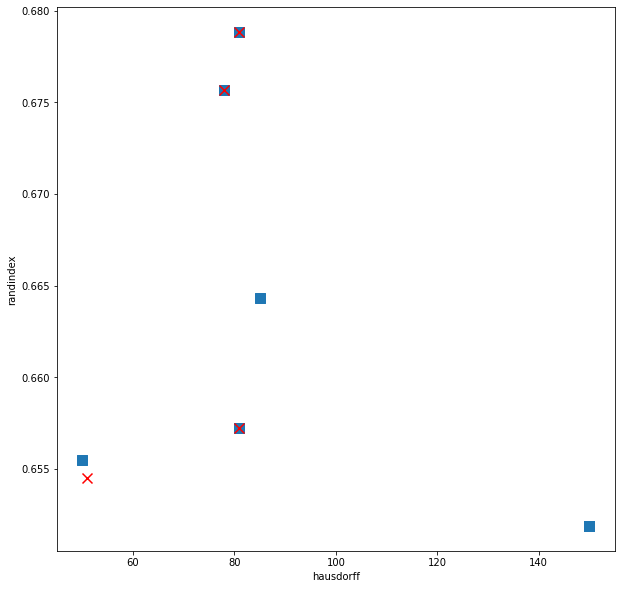

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
# all the log_normal
tmp_df = cp_df[cp_df['algo'] == 'bayes'].reset_index()
tmp_df.loc[(tmp_df.index % 6 < 3)].plot.scatter('hausdorff', 'randindex', ax=ax , marker='s', s=10**2)

# all the normal
tmp_df = cp_df[cp_df['algo'] == 'bayes'].reset_index()
tmp_df.loc[(tmp_df.index % 6 > 3)].plot.scatter('hausdorff', 'randindex', ax=ax, c='r', marker='x', s=10**2)

##### STL vs raw-signal

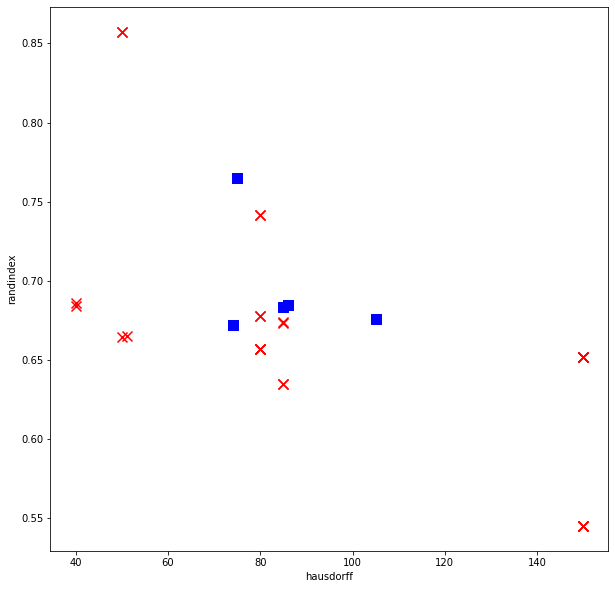

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
cp_df[cp_df['decomp'] == 'STL'].plot.scatter('hausdorff', 'randindex', c='r', marker='x', s=10**2, ax=ax)
cp_df[cp_df['decomp'] != 'STL'].plot.scatter('hausdorff', 'randindex', c='b', marker='s', s=10**2, ax=ax)

#### effect on STL for change detection algorithms

['bayes' 'pelt' 'binseg' 'window']


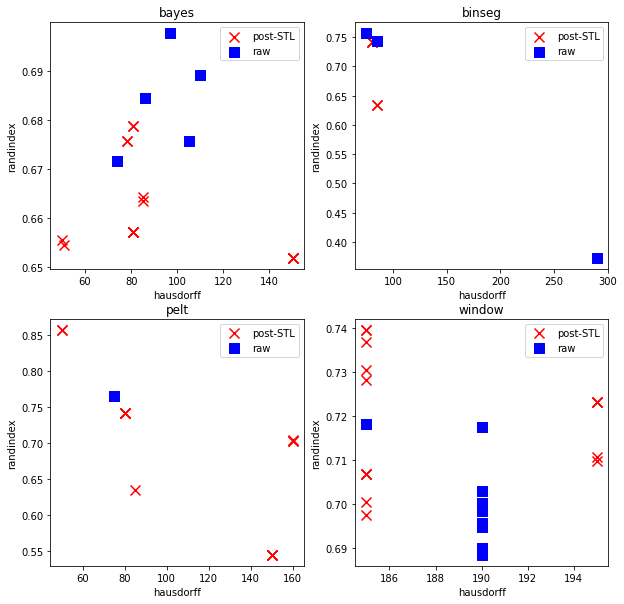

In [ ]:
unique_algos = cp_df['algo'].unique()

print(unique_algos)

fig, ax = plt.subplots(int(len(unique_algos)/2),2 , figsize=(10,10))

for idx, algo in enumerate(unique_algos):
  stl_df = cp_df[cp_df['decomp'] == 'STL']
  stl_df[stl_df['algo'] == algo].plot.scatter('hausdorff', 'randindex', c='r', marker='x', s=10**2, ax=ax[idx % 2, idx //2], label='post-STL')
  raw_df = cp_df[cp_df['decomp'] != 'STL']
  raw_df[raw_df['algo'] == algo].plot.scatter('hausdorff', 'randindex', c='b', marker='s', s=10**2, ax=ax[idx % 2, idx //2], label='raw')
  ax[idx % 2, idx //2].set_title(algo)

In [ ]:
5 // 2

2

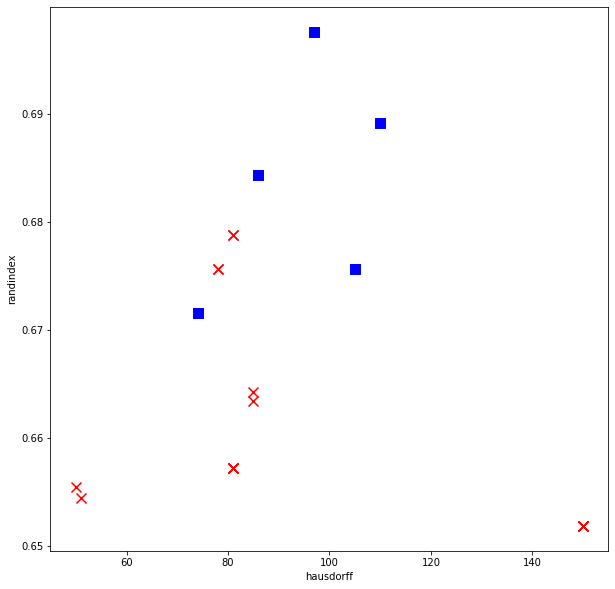

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
stl_df = cp_df[cp_df['decomp'] == 'STL']
stl_df[stl_df['algo'] == 'bayes'].plot.scatter('hausdorff', 'randindex', c='r', marker='x', s=10**2, ax=ax)
raw_df = cp_df[cp_df['decomp'] != 'STL']
raw_df[raw_df['algo'] == 'bayes'].plot.scatter('hausdorff', 'randindex', c='b', marker='s', s=10**2, ax=ax)

## GET BEST PARAMS From signal 4

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    #no_none_cp_df = cp_df[cp_df.notnull().all(axis=1)]
    display(cp_df[(cp_df['signal_no'] == 4) & (cp_df['ann_err'] > -2)][['algo','pred_bp','decomp','params']])
    for idx, row in cp_df[(cp_df['signal_no'] == 3) & (cp_df['ann_err'] > -2)].iterrows():
      print(row['algo'], row['params'])


,algo,pred_bp,decomp,params
112,pelt,"[5, 15, 30, 40, 60, 70, 80, 85, 95, 110, 125, ...",STL,{'decomp_algo': 'STL'}
114,binseg,"[5, 15, 30, 40, 60, 70, 80, 85, 95, 110, 115, ...",STL,{'decomp_algo': 'STL'}


bayes {'decomp_algo': 'STL', 'distribution': 'log_normal', 'log_odds_threshold': 0}
bayes {'decomp_algo': 'STL', 'distribution': 'normal', 'log_odds_threshold': 0}
pelt {'decomp_algo': 'STL'}
binseg {'decomp_algo': 'STL'}


In [ ]:
np.std(cp_df['signal'].iloc[0])**2 * len(cp_df['signal'].iloc[0])

13.158915608797408

In [ ]:
def pen_mBIC(signal):
  length = len(signal)
  summa = 0
  for idx, x in enumerate(signal):
    if idx+1 != length:
      summa += np.log(signal[idx+1] - signal[idx] / length)
  return (3 * length * np.log(length) + summa)

pen_mBIC(cp_df['signal'].iloc[0]) 

7053.582846633705

In [ ]:
0.5 * np.log(len(cp_df['signal'].iloc[0])) * len(cp_df['signal'].iloc[0])

1226.2985035784488

In [ ]:
len(cp_df['signal'].iloc[0])

408

In [ ]:
len(cp_df['signal'].iloc[0]) * 0.045

18.36

In [ ]:
np.mean([x for x in np.arange(0.01,0.09,0.01) ])

0.045

# BFAST test(doesnt work only gets the first break)

In [ ]:
from bfast import BFASTMonitor
from datetime import datetime

model = BFASTMonitor(
            datetime(1988,5,30),
            freq=12,
            k=3,
            hfrac=0.5,
            trend=True,
            level=0.05,
            backend='python',
            verbose=2
            )

print(len(harm_df.index))

fake_signal = fake_signal.reshape(408,1,1)
#print(fake_signal)
model.fit(fake_signal, harm_df.index,n_chunks=5, nan_value=0)

408
Processing row 0


In [ ]:
[idx for idx, date in enumerate(harm_df.index) if date == pd.Timestamp(datetime(1988,5,31)) ]

[28]

In [ ]:
model.breaks

array([[22]], dtype=int32)

In [ ]:
model.means

array([[-42.450153]], dtype=float32)

In [ ]:
! pip install bfast

     |████████████████████████████████| 624kB 2.6MB/s 
     |████████████████████████████████| 10.1MB 5.9MB/s 
     |████████████████████████████████| 727kB 48.3MB/s 
     |████████████████████████████████| 5.4MB 49.1MB/s 
     |████████████████████████████████| 24.8MB 116kB/s 
     |████████████████████████████████| 12.6MB 18.0MB/s 
     |████████████████████████████████| 71kB 8.8MB/s 
  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=5d71ea56a01d565b5b3af934d54b23abe61cc2f59edf9ef66f5ba52234bb5e25
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
  Created wheel for pytools: filename=pytools-2020.3.1-py2.py3-none-any.whl size=65243 sha256=77df653abce72d5c1a45eade83bd37aba39cf6cd42608bc6e4910b7da13725a8
  Stored in directory: /root/.cache/pip/wheels/ac/01/07/fe484d8aae398b7f6150dae468a53887f0e7e265f1fc7fc975
Successfully built wget pytools
ERROR: xarray 0.15.1 has requirement pandas>=0.25, but you'll

Date
1986-01-31    0.588876
1986-02-28    0.586853
1986-03-31    0.584872
1986-04-30    0.582922
1986-05-31    0.580992
                ...   
2019-08-31    0.647704
2019-09-30    0.647751
2019-10-31    0.647807
2019-11-30    0.647863
2019-12-31    0.647913
Length: 408, dtype: float64

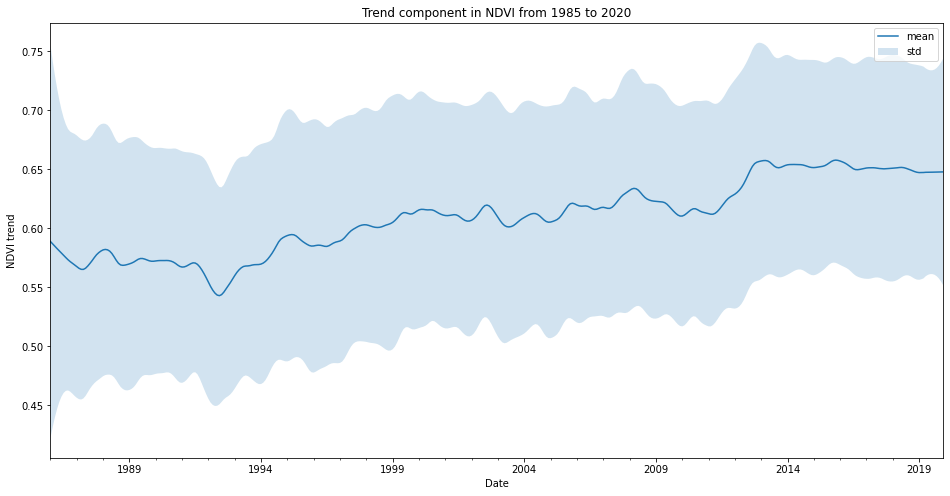

In [ ]:
get_mean_and_std(trend_df, 'NDVI trend', 'Trend component in NDVI from 1985 to 2020')

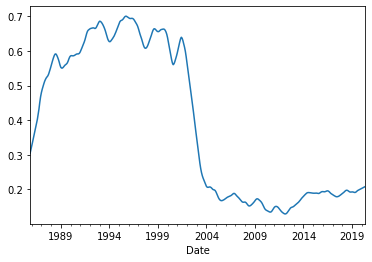

In [ ]:
trend_df['Z2'].plot()

# casual Impact

## load temperature files

In [ ]:
! ls data_files/monthly_means

monthly_mean_pp_EBTRN.csv  monthly_mean_tg_EBTRN.csv  monthly_mean_tx_EBTRN.csv
monthly_mean_rr_EBTRN.csv  monthly_mean_tn_EBTRN.csv


In [ ]:
climate_data_path = 'data_files/monthly_means/'

pp_df = pd.read_csv(climate_data_path + 'monthly_mean_pp_EBTRN.csv', parse_dates=True).set_index(['Date'])
rr_df = pd.read_csv(climate_data_path + 'monthly_mean_rr_EBTRN.csv', parse_dates=True).set_index(['Date'])
tg_df = pd.read_csv(climate_data_path + 'monthly_mean_tg_EBTRN.csv', parse_dates=True).set_index(['Date'])
tn_df = pd.read_csv(climate_data_path + 'monthly_mean_tn_EBTRN.csv', parse_dates=True).set_index(['Date'])
tx_df = pd.read_csv(climate_data_path + 'monthly_mean_tx_EBTRN.csv', parse_dates=True).set_index(['Date'])

In [ ]:
pp_df.head()

,AHFS,OXIA15,PILI10,OSSA13,OSSA06,PIND13,GRAM15,VERMTL,VERMSC,VERM19,VERM17,VERM16,VERM11,VERM10,VERM08,VERM15,VERM14,VERM13,PAGG16,PAGG09,PAIK11,SERR15,KAR,HB,NO,SO,RU,VA,AFO,SHW,NET,OAH,FOC,BWS,LAR,FAH,rezi,befa,maly,XAMD,...,L,S,Z1,Z2,ANFS,ASFS,BNFS,BSFS,HE,HA,BR,ZE,ME,CaH,CaL,CaS,GoL,GoS,KlL,KlS,OeS,SeL,Ses,UnL,UnS,RIED,MTCIM,CANS,MTTER,MTPOL,SL_3,SL_4,CUCU,LAEA,LAEB,FELSU,FELSM,DomEmsU,ZOFI,ELFI
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1980-01-31,NaN,1016.980660,1018.019370,1018.241951,1018.241951,1017.964531,1018.941951,1019.290338,1019.290338,1019.290338,1019.290338,1019.290338,1019.264531,1019.264531,1019.264531,1019.290338,1019.290338,1019.290338,1019.870983,1019.870983,1019.570983,1019.748402,1017.993564,1016.354854,1016.400015,1017.158080,1017.158080,1017.019370,1015.093564,1015.041951,1014.848402,1014.806467,1014.693564,1014.680660,1014.574209,1014.561305,1019.606467,1018.103241,1018.412918,1019.619370,...,1021.435499,1021.570983,1021.590338,1021.661306,1019.832273,1019.832273,1020.196789,1020.196789,1016.683886,1016.919370,1016.403241,1018.277435,1018.032273,1017.267757,1017.177435,1017.267757,1017.148402,1017.148402,1017.125822,1017.125822,1016.945176,1016.864531,1016.864531,1016.951628,1016.951628,1018.229047,1014.764531,1019.161306,1014.609693,1016.538725,1021.206467,1021.206467,1021.112918,1017.887112,1017.887112,1017.883886,1017.883886,1017.883886,1017.961305,1017.783886
1980-02-29,NaN,1018.720705,1019.717257,1020.068981,1020.068981,1020.079326,1021.124153,1021.182774,1021.182774,1021.182774,1021.182774,1021.182774,1021.117257,1021.117257,1021.117257,1021.182774,1021.182774,1021.182774,1021.465532,1021.465532,1021.296567,1021.213808,1022.437946,1021.603463,1021.655188,1022.668981,1022.765532,1022.372429,1017.820705,1017.720705,1017.220705,1017.165532,1017.237946,1017.265532,1017.162084,1017.310360,1023.003464,1021.406912,1021.651739,1023.041395,...,1024.665533,1024.682774,1024.713808,1024.741395,1023.282774,1023.282774,1023.558636,1023.558636,1020.137946,1020.465532,1020.144843,1021.379326,1021.258636,1020.258636,1020.220705,1020.258636,1020.241395,1020.241395,1020.224153,1020.224153,1020.158636,1020.151739,1020.151739,1020.127601,1020.127601,1021.420705,1020.003463,1023.200015,1019.768981,1020.503463,1024.624153,1024.624153,1024.496567,1021.779326,1021.779326,1021.720705,1021.720705,1021.720705,1021.782774,1021.724153
1980-03-31,NaN,1012.719370,1013.190338,1013.238725,1013.238725,1013.425822,1014.196789,1014.061305,1014.061305,1014.061305,1014.061305,1014.061305,1014.006467,1014.006467,1014.006467,1014.061305,1014.061305,1014.061305,1014.348402,1014.348402,1014.054854,1014.064531,1014.632273,1014.380660,1014.438725,1015.590338,1016.164531,1016.080660,1009.645176,1009.612918,1009.464531,1009.441951,1009.490338,1009.490338,1009.477434,1009.470983,1012.683886,1011.625822,1011.929047,1013.058080,...,1017.229047,1016.561305,1016.577435,1016.745176,1013.683886,1013.683886,1014.290338,1014.290338,1012.203241,1012.593563,1012.403241,1012.929047,1012.493563,1012.283886,1012.354854,1012.283886,1012.580660,1012.580660,1012.306467,1012.306467,1011.974209,1011.887112,1011.887112,1011.945176,1011.945176,1011.100015,1011.716144,1013.358080,1011.596789,1013.561305,1016.638725,1016.638725,1016.216144,1011.758080,1011.758080,1011.570983,1011.570983,1011.570983,1011.938725,1011.825822
1980-04-30,NaN,1012.326682,1011.936682,1011.883348,1011.883348,1013.043348,1013.863348,1013.050015,1013.050015,1013.050015,1013.050015,1013.050015,1012.956682,1012.956682,1012.956682,1013.050015,1013.050015,1013.050015,1012.596682,1012.596682,1012.843348,1012.350015,1015.003348,1014.576682,1014.570015,1014.943348,1014.753348,1014.756682,1021.756682,1021.800015,1022.166682,1022.180015,1021.903349,1021.830015,1021.553349,1021.023349,1013.713348,1010.973348,1011.216682,1017.006682,...,1013.113348,1013.073348,1013.090015,1013.126682,1012.656682,1012.656682,1012.920015,1012.920015,1016.280015,1016.240015,10

## checking if climate trend matches ndvi

### NO

#### raw comparison

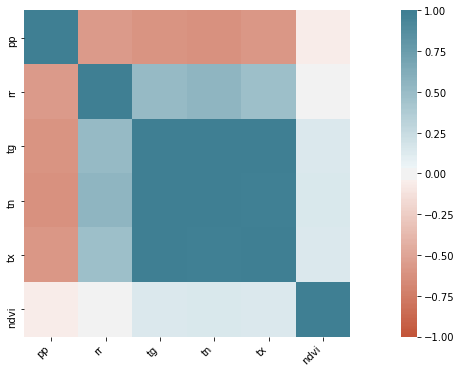

In [ ]:
def site_climate_raw_pairwise_plot(site_name):

  site_climate_data = get_site_climate_date(site_name)
  site_data = site_climate_data
  site_data['ndvi'] = harm_df[site_name]

  x = site_data.values
  min_max_scaler = preprocessing.MinMaxScaler()
  x_scaled = min_max_scaler.fit_transform(x)
  df = pd.DataFrame(x_scaled)
  df.columns = site_data.columns

  ax = sns.pairplot(df, corner=True)
  #plt.title(site_name)

  
  plt.show()

def site_climate_raw_corr_plot(site_name):

  site_climate_data = get_site_climate_date(site_name)
  site_data = site_climate_data
  site_data['ndvi'] = harm_df[site_name]

  x = site_data.values
  min_max_scaler = preprocessing.MinMaxScaler()
  x_scaled = min_max_scaler.fit_transform(x)
  df = pd.DataFrame(x_scaled)
  df.columns = site_data.columns

  corr = df.corr()
  ax = sns.heatmap(
      corr, 
      vmin=-1, vmax=1, center=0,
      cmap=sns.diverging_palette(20, 220, n=200),
      square=True
  )
  ax.set_xticklabels(
      ax.get_xticklabels(),
      rotation=45,
      horizontalalignment='right'
  )

  
  plt.show()

site_climate_raw_corr_plot('Z2')

#### trend comparison

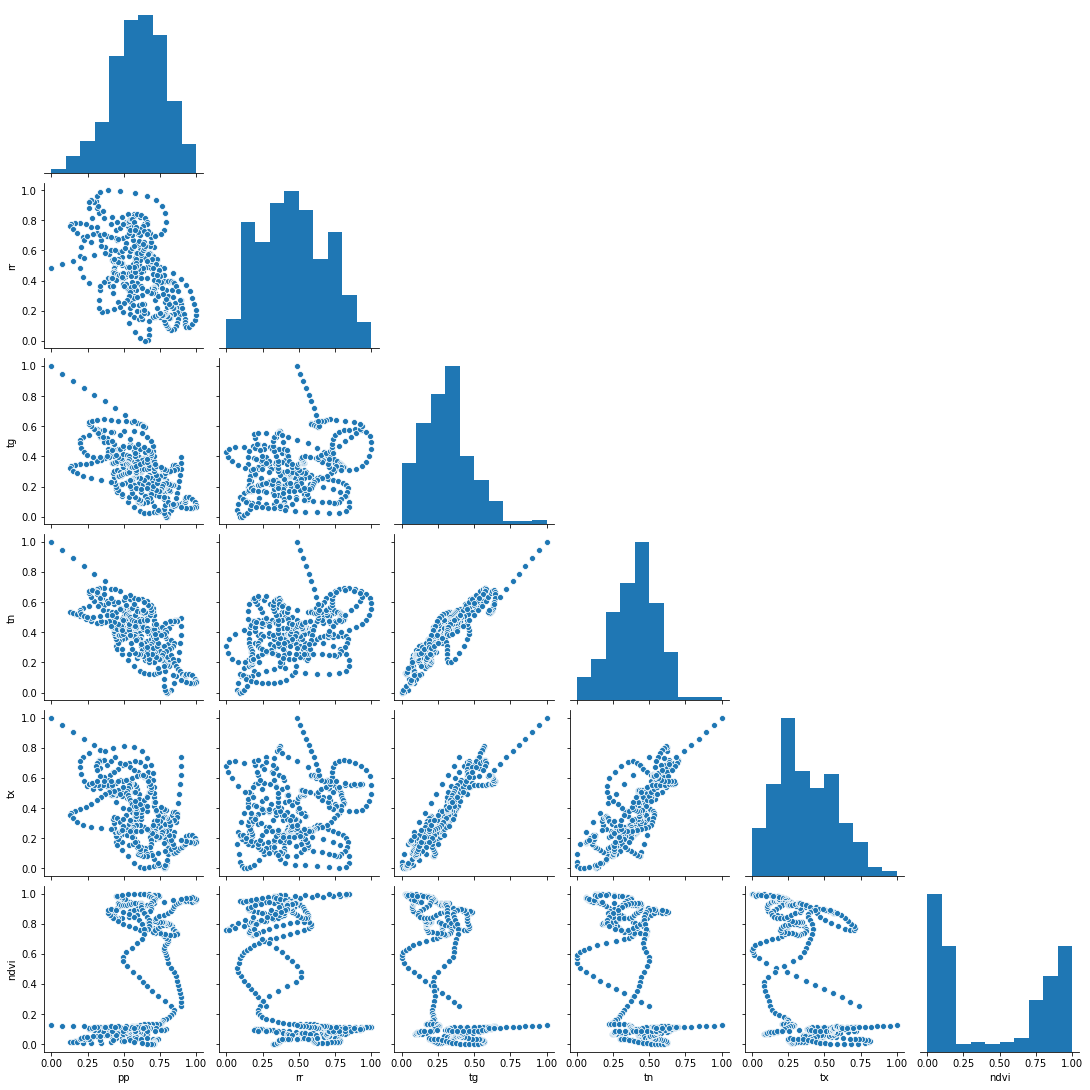

In [ ]:
import pandas as pd
from sklearn import preprocessing

def site_climate_trend_corr_plot(site_name):
  #fig, ax = plt.subplots()
  site_climate_data = get_site_climate_date(site_name)
  site_climate_trend = extract_climate_trend(site_climate_data)
  site_trend_data = site_climate_trend
  site_trend_data['ndvi'] = trend_df[site_name]

  #site_trend_data.plot(ax=ax)
  # trend_df['NO'].plot(ax=ax ,label='ndvi')
  # site_climate_trend[['rr','tx','tn','tg']].plot(ax=ax)
  #lt.legend()



  x = site_trend_data.values #returns a numpy array
  min_max_scaler = preprocessing.MinMaxScaler()
  x_scaled = min_max_scaler.fit_transform(x)
  df = pd.DataFrame(x_scaled)
  df.columns = site_trend_data.columns

  # df.plot(ax=ax)
  # ax.set_title(str(site_name))

  ax = sns.pairplot(df, corner=True)
  #plt.title(site_name)
  plt.show()

site_climate_corr_plot('Z2')

<AxesSubplot:>

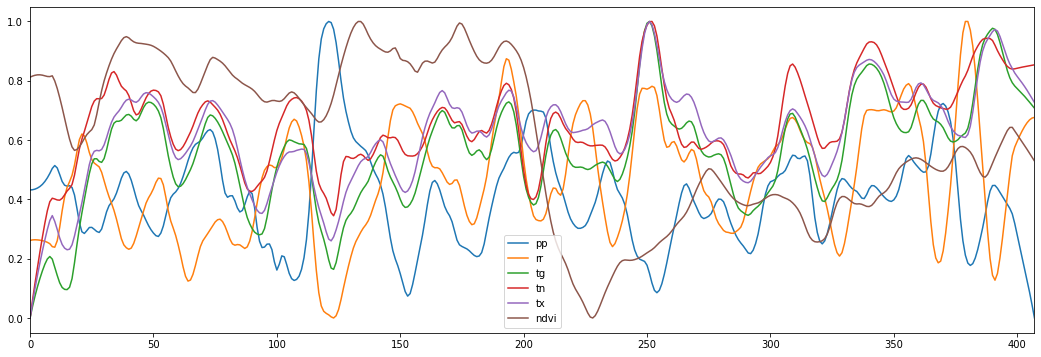

In [ ]:
import pandas as pd
from sklearn import preprocessing

x = site_trend_data.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
df.columns = site_trend_data.columns
df.plot()

# self made functions

In [ ]:
def format_cols_casualimpact(df, y_col_name):
  '''
  description: formating column names to fit casual impact function

                example of format:
                data = pd.DataFrame({'x0': x0, 'x1': x1, 'y': y}, 
                                     columns=['y', 'x0', 'x1'])

  returns: dataframe with correct columns names as seen in example

  '''
  old_list = df.columns.to_list()
  new_cols = {}
  
  for idx, col in enumerate(old_list):
    #print(col)
    if col != y_col_name:
      new_cols['x'+str(idx)] = col
    else:
      new_cols['y'] = y_col_name

  df.columns = new_cols

  return(df)

# building climate dataframe for sites

In [ ]:
harm_df.loc['2019-08-31']

FMMOL     0.857484
E12       0.766765
ELFI      0.735992
BBOB      0.861693
VERMTL    0.517606
            ...   
LE50      0.860477
NGLS      0.692815
AFO       0.853072
M11       0.856861
BB        0.771970
Name: 2019-08-31 00:00:00, Length: 590, dtype: float64

# causal impact helper functions

,ts,log_odds,start_end,prob_ts,date,pos_prob,no_days
0,207,195.197642,"(0, 408)","[6.360737453968167e-236, 1.5742005404290737e-2...",2003-04-30 00:00:00,90.7093,408
1,14,13.952107,"(0, 207)","[7.502013110776383e-16, 5.481022487030289e-13,...",1987-03-31 00:00:00,100,207
2,7,0.412204,"(0, 14)","[0.01941240930211261, 0.05415222969856927, 0.1...",1986-08-31 00:00:00,50.5495,14
3,194,24.547503,"(14, 207)","[9.714670557548048e-36, 3.497055165397526e-35,...",2002-03-31 00:00:00,93.007,193
4,62,14.465142,"(14, 194)","[3.556354707785627e-26, 9.581691353204926e-25,...",1991-03-31 00:00:00,99.1009,180
5,22,0.801514,"(14, 62)","[5.7938193054957735e-05, 0.0007636829267598534...",1987-11-30 00:00:00,97.8022,48
6,169,5.100607,"(62, 194)","[3.612214512434175e-18, 4.485022661858404e-18,...",2000-02-29 00:00:00,61.9381,132
7,337,21.513425,"(207, 408)","[2.9888360870439482e-36, 5.219450310220221e-35...",2014-02-28 00:00:00,100,201
8,258,23.359990,"(207, 337)","[5.280984215966187e-17, 1.8266598503271675e-15...",2007-07-31 00:00:00,65.8342,130
9,229,11.558469,"(207, 258)","[7.650144296613023e-10, 1.3918653314861961e-08...",2005-02-28 00:00:00,71.2288,51


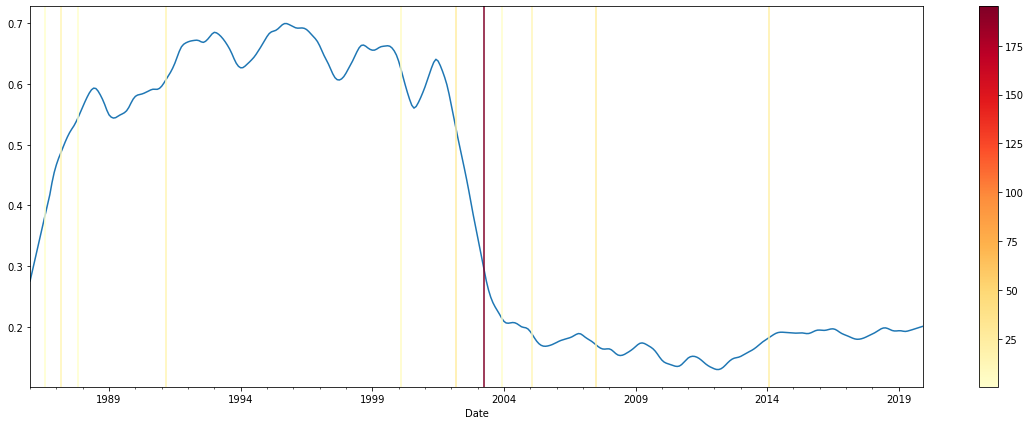

In [ ]:
def get_change_points(df, detector):
  '''
  description: converts the list of idx from change point detector to 
  '''
  date_list = []
  for idx, row in detector.change_points['traj_0'].iterrows():
    date_list.append(df.index[row['ts']])
  return date_list

def get_change_points_plot(df, detector):
  date_list = get_change_points(df, detector)
  fig, ax = plt.subplots(figsize=(20,7))

  #sorting the points for color mapping
  point_df = detector.change_points['traj_0']
  sorted_df = point_df.sort_values(['log_odds'])
  sorted_odds = np.array(sorted_df['log_odds'])
  odds = np.array(point_df['log_odds'])

  #display(point_df)
  #print(date_list)
  
  #display(df)

  #mapping the odds
  jet = plt.get_cmap('YlOrRd')
  cNorm = colors.Normalize(vmin=sorted_odds[0], vmax=sorted_odds[-1])
  scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
  plt.colorbar(scalarMap)
  

  #colors = color_map()
  #print(colors.shape)
  df.plot(ax=ax)
  
  for idx, date in enumerate(date_list):
    colorVal = scalarMap.to_rgba(odds[idx])
    plt.axvline(date, color=colorVal)

def get_site_climate_date(site_id):
  if not os.path.exists('data_files/site_climate_data'):
    os.makedirs('data_files/site_climate_data')

  climate_df = pd.DataFrame()

  if site_id in pp_df:
    climate_df['pp'] = pp_df[site_id]
  if site_id in rr_df:
    climate_df['rr'] = rr_df[site_id]
  if site_id in tg_df:
    climate_df['tg'] = tg_df[site_id]
  if site_id in tn_df:
    climate_df['tn'] = tn_df[site_id]
  if site_id in tx_df:
    climate_df['tx'] = tx_df[site_id]
  #climate_df['ndvi'] = harm_df[site_id]

  climate_df = climate_df.merge(harm_df[site_id], left_index=True, right_index=True)

  climate_df = climate_df.rename(columns={site_id: 'ndvi'})

  return climate_df

def extract_climate_trend(df, trend='STL'):
  '''
    input_params: 
      df: input the dataframe of which the trends are to be extracted from
          requirements for the dataframe:
          - dataframe index need to be datetime,
          - datetime index should be sorted
          - should be a monthly resampling
  '''
  climate_trend_df = pd.DataFrame()

  if trend == 'STL':
    yr_list = df.index.year
    #print(yr_list[-1])
    #print(yr_list[0])
    seasons = yr_list[-1] - yr_list[0]

    if seasons % 2 == 0:
      seasons += 1
    

    for col in df:
      stl = STL(df[col], period=12, seasonal=seasons, robust=True)
      res = stl.fit()
      #print(res.trend)
      climate_trend_df[col] = res.trend
      
  return climate_trend_df

def format_cols_casualimpact(df, y_col_name):
  '''
  description: formating column names to fit casual impact function

                example of format:
                data = pd.DataFrame({'x0': x0, 'x1': x1, 'y': y}, 
                                     columns=['y', 'x0', 'x1'])

  returns: dataframe with correct columns names as seen in example

  '''
  old_list = df.columns.to_list()
  new_cols = {}
  df_copy = df.copy()

  for idx, col in enumerate(old_list):
    #print(col)
    if col != y_col_name:
      new_cols['x'+str(idx)] = col
    else:
      new_cols['y'] = y_col_name

  df_copy.columns = new_cols

  return df_copy

def get_casual_impact(site_id):
  z2_climate_df = get_site_climate_date(site_id)
  z2_climate_trend_df = extract_climate_trend(z2_climate_df)
  #z2_climate_trend_df.plot()

  detector = cpDetector([z2_climate_trend_df['ndvi']], distribution='log_normal', log_odds_threshold=0)
  detector.detect_cp()

  # get the dates
  date_list = get_change_points(z2_climate_trend_df, detector)

  #preparing dataframe for casual impact package
  cs_format_trend_df = format_cols_casualimpact(z2_climate_trend_df, 'ndvi')

  #alternate format for og data
  cs_format_df = format_cols_casualimpact(z2_climate_df, 'ndvi')

  first_date = cs_format_trend_df.index[0]
  last_date = cs_format_trend_df.index[-1]

  change_points_df = detector.change_points['traj_0'].copy()

  change_points_df['date'] = len(change_points_df.index) * [None]
  change_points_df['pos_prob'] = len(change_points_df.index) * [None]
  change_points_df['no_days'] = len(change_points_df.index) * [None]


  #display(change_points_df)

  for idx, row in detector.change_points['traj_0'].iterrows():
      date = z2_climate_trend_df.index[row['ts']]
      pre_end_date = z2_climate_trend_df.index[row['ts'] - 1]
      post_end_date = z2_climate_trend_df.index[row['ts'] + 1]

      pre_period = [first_date, pre_end_date]
      post_period = [post_end_date, last_date]

      cs_df = pd.DataFrame()
      ci = CausalImpact(cs_format_df, pre_period, post_period, nseasons=[{'period':12}])

      change_points_df.loc[idx, 'date'] = date
      change_points_df.loc[idx, 'pos_prob'] = (1 - ci.p_value) * 100
      change_points_df.loc[idx, 'no_days'] = change_points_df.loc[idx, 'start_end'][1] - change_points_df.loc[idx, 'start_end'][0]
      #cs_dict['timestep'] = row['ts']
      #change_points_df = change_points_df.append(cs_df)
      #print('DATE:', date)
      #print('p value:' , (1 - ci.p_value) * 100 ,'%')
      #print(row['ts'])

  
  #just to display the segmentation
  get_change_points_plot(z2_climate_trend_df['ndvi'], detector)

  return change_points_df

get_casual_impact('Z2')

In [ ]:
z2_climate_trend_df

,pp,rr,tg,tn,tx,ndvi
Date,,,,,,
1985-11-30,1017.388282,1.342939,8.002962,2.927512,14.276385,0.302118
1985-12-31,1017.529961,1.285568,7.884578,2.731739,14.210456,0.312399
1986-01-31,1017.663167,1.230218,7.761462,2.533914,14.135904,0.323010
1986-02-28,1017.786991,1.177146,7.633232,2.334060,14.052316,0.333878
1986-03-31,1017.901305,1.126458,7.498561,2.130608,13.959244,0.344932
...,...,...,...,...,...,...
2019-08-31,1015.491457,1.573576,10.010013,3.787184,15.902511,0.195813
2019-09-30,1015.135207,1.546093,10.222190,3.988781,16.095231,0.196957
2019-10-31,1014.773829,1.517136,10.441473,4.192182,16.295230,0.198061


#Sites

# Z2

In [ ]:
detector = cpDetector([trend_df['Z2']], distribution='log_normal', log_odds_threshold=0)
detector.detect_cp()

05:40:02 INFO cpDetector: =======================================
05:40:02 INFO cpDetector: Running change point detector
05:40:02 INFO cpDetector: =======================================
05:40:02 INFO cpDetector:    input observations: 1 of length [415]
05:40:02 INFO cpDetector: Running cp detector on traj 0
05:40:02 INFO cpDetector: ---------------------------------
05:40:03 INFO cpDetector:     Found a new change point at: 209!!
05:40:03 INFO cpDetector:     Found a new change point at: 14!!
05:40:03 INFO cpDetector:     Found a new change point at: 197!!
05:40:04 INFO cpDetector:     Found a new change point at: 63!!
05:40:04 INFO cpDetector:     Found a new change point at: 25!!
05:40:04 INFO cpDetector:     Found a new change point at: 172!!
05:40:05 INFO cpDetector:     Found a new change point at: 338!!
05:40:05 INFO cpDetector:     Found a new change point at: 260!!
05:40:05 INFO cpDetector:     Found a new change point at: 231!!
05:40:05 INFO cpDetector:     Found a new chang

## first trial segment demo

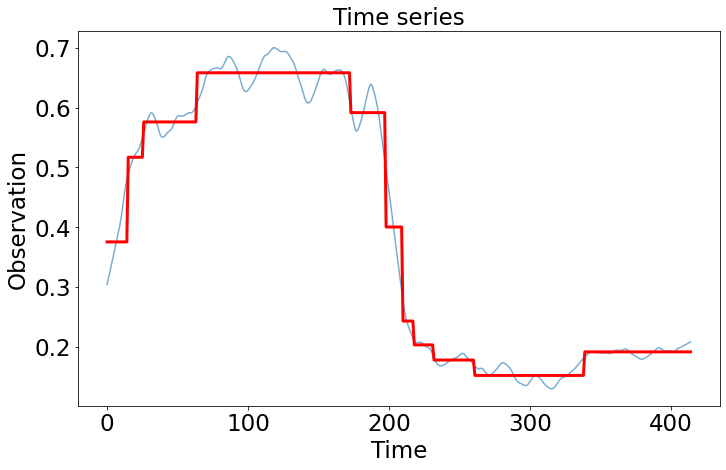

In [ ]:
import matplotlib as mpl

def plot_seg(df, detector):
  scale = 2.3

  default_font = mpl.rcParams['font.size']
  fsc = default_font*scale

  fig = plt.figure(figsize=(5*scale, 3*scale))
  ax = fig.add_subplot(111)
  plt.figure(1)
  plt.plot(np.array(df), alpha=0.6)
  plt.plot(detector.step_function['traj_%s' % 0], 'r', linewidth=3)
  ax.set_xlabel('Time', fontsize=fsc)
  ax.set_ylabel('Observation', fontsize=fsc)
  for axis in [ax.xaxis, ax.yaxis]:
      axis.set_tick_params(labelsize=fsc)
      plt.title('Time series', fontsize=fsc)

plot_seg(trend_df['Z2'], detector)

In [ ]:
detector.change_points['traj_0']

,ts,log_odds,start_end,prob_ts
0,319,31.100677,"(0, 415)","[3.055006428831893e-48, 8.151677328902007e-48,..."
1,179,47.182084,"(0, 319)","[2.4857512595006546e-76, 4.56220104296329e-76,..."
2,9,17.444482,"(0, 179)","[4.334363789354225e-13, 2.547732673152555e-09,..."
3,383,1.932580,"(319, 415)","[3.6190105403618986e-22, 1.1585752922036479e-2..."


## segmentation w color map

In [ ]:
import matplotlib.colors as colors
import matplotlib.cm as cmx

def get_change_points(df, detector):
  date_list = []
  for idx, row in detector.change_points['traj_0'].iterrows():
    date_list.append(df.index[row['ts']])
  return date_list

def get_change_points_plot(df, detector):
  date_list = get_change_points(df, detector)
  fig, ax = plt.subplots(figsize=(20,7))

  #sorting the points for color mapping
  point_df = detector.change_points['traj_0']
  sorted_df = point_df.sort_values(['log_odds'])
  sorted_odds = np.array(sorted_df['log_odds'])
  odds = np.array(point_df['log_odds'])

  #display(point_df)
  #print(date_list)
  
  #display(df)

  #mapping the odds
  jet = plt.get_cmap('YlOrRd')
  cNorm = colors.Normalize(vmin=sorted_odds[0], vmax=sorted_odds[-1])
  scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
  plt.colorbar(scalarMap)
  

  #colors = color_map()
  #print(colors.shape)
  df.plot(ax=ax)
  
  for idx, date in enumerate(date_list):
    colorVal = scalarMap.to_rgba(odds[idx])
    plt.axvline(date, color=colorVal)

def get_all_casual_impacts(df):
  stl = STL(df[col], period=12, seasonal=seasons, robust=True)
  res = stl.fit()

detector = cpDetector([trend_df['Z2']], distribution='log_normal', log_odds_threshold=0)
detector.detect_cp()
get_change_points_plot(trend_df['Z2'], detector)

NameError: ignored

## semgentation from casual impact dataframe

to calculate the casual impact for each breakpoint

In [ ]:
def get_segment_data(site_id):
  ci_df = get_site_climate_date('Z2')
  

In [ ]:
color_map = plt.cm.get_cmap("rainbow")
color = color_map(0.4)
color

(0.30000000000000004, 0.9510565162951535, 0.8090169943749475, 1.0)

# NO

06:10:04 INFO cpDetector: =======================================
06:10:04 INFO cpDetector: Running change point detector
06:10:04 INFO cpDetector: =======================================
06:10:04 INFO cpDetector:    input observations: 1 of length [415]
06:10:04 INFO cpDetector: Running cp detector on traj 0
06:10:04 INFO cpDetector: ---------------------------------
06:10:05 INFO cpDetector:     Found a new change point at: 207!!
06:10:05 INFO cpDetector:     Found a new change point at: 128!!
06:10:06 INFO cpDetector:     Found a new change point at: 89!!
06:10:06 INFO cpDetector:     Found a new change point at: 32!!
06:10:06 INFO cpDetector:     Found a new change point at: 12!!
06:10:07 INFO cpDetector:     Found a new change point at: 352!!
06:10:07 INFO cpDetector:     Found a new change point at: 263!!
06:10:07 INFO cpDetector:     Found a new change point at: 240!!
06:10:07 INFO cpDetector:     Found a new change point at: 220!!
06:10:08 INFO cpDetector: Generating step fucnt

,ts,log_odds,start_end,prob_ts
0,207,100.493481,"(0, 415)","[1.903471265656033e-133, 5.442188619771516e-13..."
1,128,3.976067,"(0, 207)","[2.0317618980756413e-20, 1.2294873296222704e-1..."
2,89,1.899935,"(0, 128)","[3.019304237975479e-10, 2.0138451131358193e-09..."
3,32,4.833766,"(0, 89)","[4.909854076703714e-13, 3.2456766822584643e-12..."
4,12,3.586564,"(0, 32)","[9.403789861713232e-14, 1.2531289151612647e-12..."
5,352,50.866740,"(207, 415)","[2.509997719381426e-44, 1.8632022801804697e-44..."
6,263,28.016805,"(207, 352)","[8.465286969543067e-32, 9.248948797959035e-32,..."
7,240,5.640081,"(207, 263)","[0.000430304657732417, 0.005101972722326527, 0..."
8,220,6.704294,"(207, 240)","[1.2777607447192376e-05, 0.0001574589601682190..."


Date
1985-11-30    0.639888
1985-12-31    0.641444
1986-01-31    0.642980
1986-02-28    0.644385
1986-03-31    0.645540
                ...   
2020-01-31    0.516802
2020-02-29    0.512501
2020-03-31    0.508243
2020-04-30    0.504046
2020-05-31    0.499907
Name: NO, Length: 415, dtype: float64

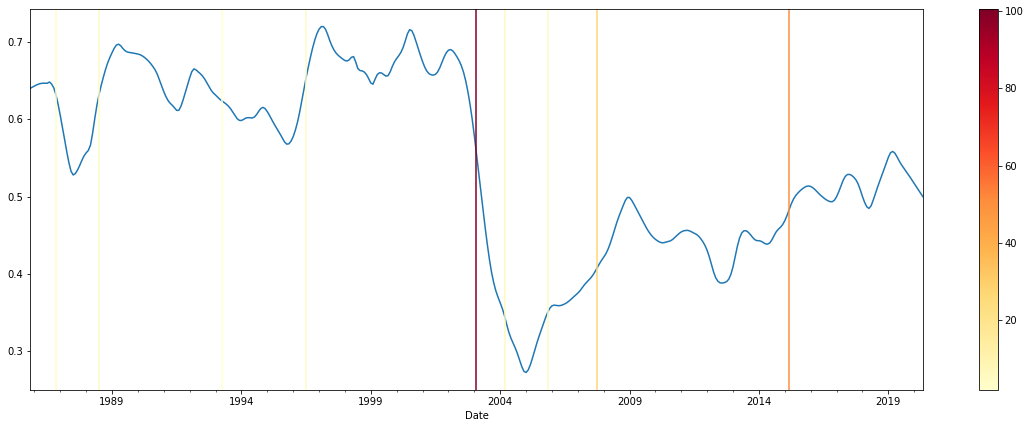

In [ ]:
one_site_display('NO')

17:17:37 INFO cpDetector: =======================================
17:17:37 INFO cpDetector: Running change point detector
17:17:37 INFO cpDetector: =======================================
17:17:37 INFO cpDetector:    input observations: 1 of length [410]
17:17:37 INFO cpDetector: Running cp detector on traj 0
17:17:37 INFO cpDetector: ---------------------------------
17:17:38 INFO cpDetector:     Found a new change point at: 207!!
17:17:38 INFO cpDetector:     Found a new change point at: 128!!
17:17:38 INFO cpDetector:     Found a new change point at: 90!!
17:17:38 INFO cpDetector:     Found a new change point at: 32!!
17:17:38 INFO cpDetector:     Found a new change point at: 12!!
17:17:39 INFO cpDetector:     Found a new change point at: 352!!
17:17:39 INFO cpDetector:     Found a new change point at: 263!!
17:17:40 INFO cpDetector:     Found a new change point at: 240!!
17:17:40 INFO cpDetector:     Found a new change point at: 220!!
17:17:40 INFO cpDetector: Generating step fucnt

,ts,log_odds,start_end,prob_ts,date,pos_prob,no_days
0,207,99.335411,"(0, 410)","[4.104824240856853e-133, 1.159492008082507e-13...",2003-02-28 00:00:00,59.1409,410
1,128,4.069911,"(0, 207)","[2.3432767961799493e-20, 1.4054197783349708e-1...",1996-07-31 00:00:00,53.7463,207
2,90,2.056247,"(0, 128)","[2.274886090864847e-10, 1.5137212654768169e-09...",1993-05-31 00:00:00,59.1409,128
3,32,5.115948,"(0, 90)","[3.5326454458157794e-13, 2.314946178982309e-12...",1988-07-31 00:00:00,73.3267,90
4,12,3.771012,"(0, 32)","[9.801133185663092e-14, 1.3104525676759892e-12...",1986-11-30 00:00:00,71.4286,32
5,352,47.634828,"(207, 410)","[1.128443197998935e-40, 8.465645291882693e-41,...",2015-03-31 00:00:00,89.4106,203
6,263,27.755093,"(207, 352)","[1.0998096057637517e-31, 1.1927904769510622e-3...",2007-10-31 00:00:00,72.2278,145
7,240,5.613976,"(207, 263)","[0.00042603788099896176, 0.004937320065862512,...",2005-11-30 00:00:00,62.4376,56
8,220,6.696516,"(207, 240)","[1.2825289982187148e-05, 0.0001567319383638404...",2004-03-31 00:00:00,60.6394,33


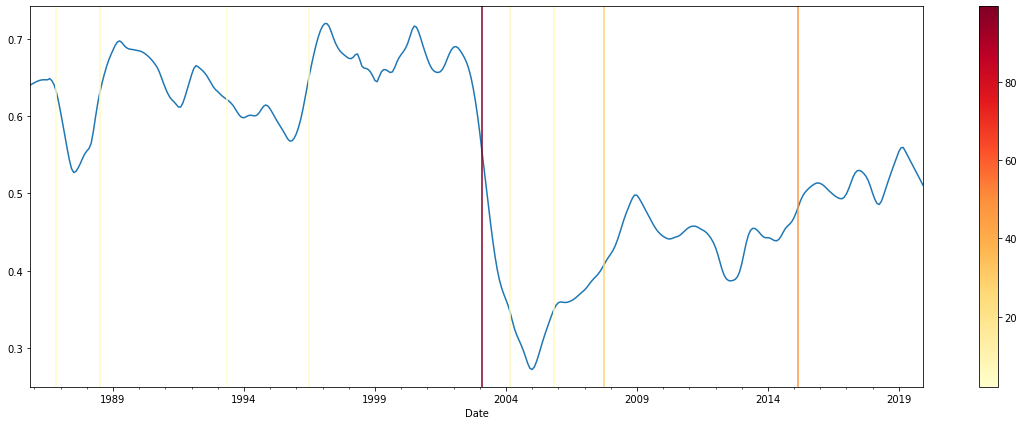

In [ ]:
get_casual_impact('NO')

# SEN

06:10:48 INFO cpDetector: =======================================
06:10:48 INFO cpDetector: Running change point detector
06:10:48 INFO cpDetector: =======================================
06:10:48 INFO cpDetector:    input observations: 1 of length [415]
06:10:48 INFO cpDetector: Running cp detector on traj 0
06:10:48 INFO cpDetector: ---------------------------------
06:10:49 INFO cpDetector:     Found a new change point at: 319!!
06:10:50 INFO cpDetector:     Found a new change point at: 179!!
06:10:50 INFO cpDetector:     Found a new change point at: 9!!
06:10:51 INFO cpDetector:     Found a new change point at: 383!!
06:10:51 INFO cpDetector: Generating step fucntion
06:10:51 INFO cpDetector: ---------------------------------
06:10:51 INFO cpDetector: Elapsed time: 2.7715368270874023


,ts,log_odds,start_end,prob_ts
0,319,31.100677,"(0, 415)","[3.055006428831893e-48, 8.151677328902007e-48,..."
1,179,47.182084,"(0, 319)","[2.4857512595006546e-76, 4.56220104296329e-76,..."
2,9,17.444482,"(0, 179)","[4.334363789354225e-13, 2.547732673152555e-09,..."
3,383,1.932580,"(319, 415)","[3.6190105403618986e-22, 1.1585752922036479e-2..."


Date
1985-11-30    0.395473
1985-12-31    0.413845
1986-01-31    0.431962
1986-02-28    0.449641
1986-03-31    0.466724
                ...   
2020-01-31    0.569887
2020-02-29    0.569695
2020-03-31    0.569306
2020-04-30    0.568645
2020-05-31    0.567702
Name: SEN, Length: 415, dtype: float64

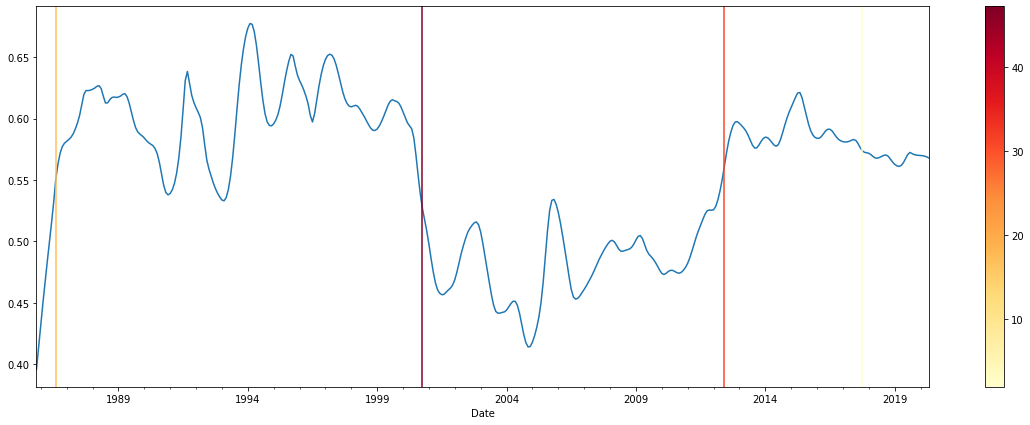

In [ ]:
detector = cpDetector([trend_df['SEN']], distribution='log_normal', log_odds_threshold=0)
detector.detect_cp()
display(detector.change_points['traj_0'])
get_change_points_plot(trend_df['SEN'], detector)

17:22:37 INFO cpDetector: =======================================
17:22:37 INFO cpDetector: Running change point detector
17:22:37 INFO cpDetector: =======================================
17:22:37 INFO cpDetector:    input observations: 1 of length [410]
17:22:37 INFO cpDetector: Running cp detector on traj 0
17:22:37 INFO cpDetector: ---------------------------------
17:22:38 INFO cpDetector:     Found a new change point at: 319!!
17:22:38 INFO cpDetector:     Found a new change point at: 180!!
17:22:39 INFO cpDetector:     Found a new change point at: 9!!
17:22:40 INFO cpDetector: Generating step fucntion
17:22:40 INFO cpDetector: ---------------------------------
17:22:40 INFO cpDetector: Elapsed time: 2.6061408519744873


,ts,log_odds,start_end,prob_ts,date,pos_prob,no_days
0,319,24.246525,"(0, 410)","[2.948428250140482e-43, 8.487434104533431e-43,...",2012-06-30 00:00:00,86.3137,410
1,180,46.711974,"(0, 319)","[2.930789009733474e-74, 5.739837203624827e-74,...",2000-11-30 00:00:00,58.7413,319
2,9,15.032808,"(0, 180)","[1.0629150333851117e-12, 4.983419090794734e-09...",1986-08-31 00:00:00,51.049,180


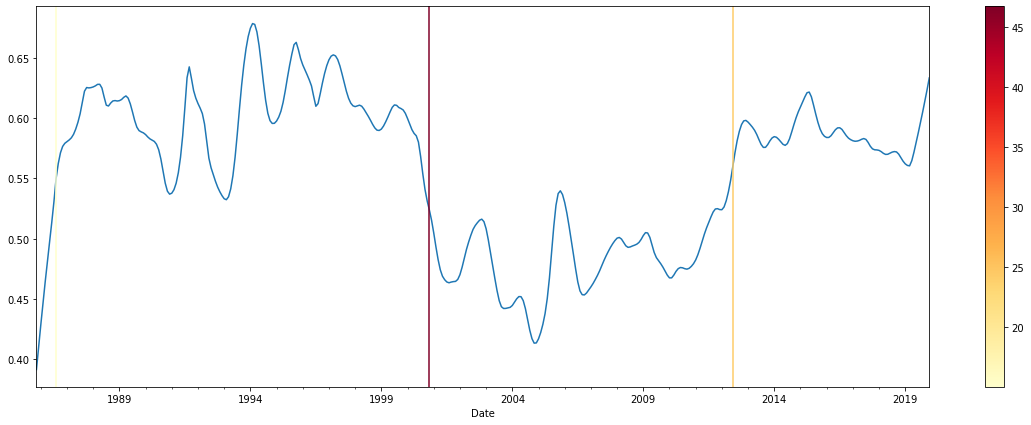

In [ ]:
get_casual_impact('SEN')

# NWGF

06:09:32 INFO cpDetector: =======================================
06:09:32 INFO cpDetector: Running change point detector
06:09:32 INFO cpDetector: =======================================
06:09:32 INFO cpDetector:    input observations: 1 of length [415]
06:09:32 INFO cpDetector: Running cp detector on traj 0
06:09:32 INFO cpDetector: ---------------------------------
06:09:33 INFO cpDetector:     Found a new change point at: 308!!
06:09:33 INFO cpDetector:     Found a new change point at: 127!!
06:09:34 INFO cpDetector:     Found a new change point at: 93!!
06:09:34 INFO cpDetector:     Found a new change point at: 214!!
06:09:34 INFO cpDetector:     Found a new change point at: 135!!
06:09:35 INFO cpDetector:     Found a new change point at: 268!!
06:09:35 INFO cpDetector:     Found a new change point at: 407!!
06:09:35 INFO cpDetector: Generating step fucntion
06:09:35 INFO cpDetector: ---------------------------------
06:09:35 INFO cpDetector: Elapsed time: 3.3597347736358643


,ts,log_odds,start_end,prob_ts
0,308,40.328032,"(0, 415)","[1.9216326956295665e-54, 8.477428540456484e-53..."
1,127,37.437128,"(0, 308)","[1.2616203969123282e-37, 5.6869284308200704e-3..."
2,93,0.707585,"(0, 127)","[9.56342801793375e-10, 2.037250124705684e-08, ..."
3,214,42.224671,"(127, 308)","[4.39322179707108e-43, 5.01932572247317e-42, 5..."
4,135,0.648966,"(127, 214)","[1.0325623689939713e-06, 5.5820921342715375e-0..."
5,268,10.624802,"(214, 308)","[6.941461722674764e-25, 3.5149820061266856e-25..."
6,407,17.457003,"(308, 415)","[1.187198970389507e-24, 1.8412123824038404e-24..."


Date
1985-11-30    0.578880
1985-12-31    0.578963
1986-01-31    0.579247
1986-02-28    0.579641
1986-03-31    0.580034
                ...   
2020-01-31    0.555565
2020-02-29    0.536833
2020-03-31    0.517157
2020-04-30    0.496471
2020-05-31    0.474825
Name: NWGF, Length: 415, dtype: float64

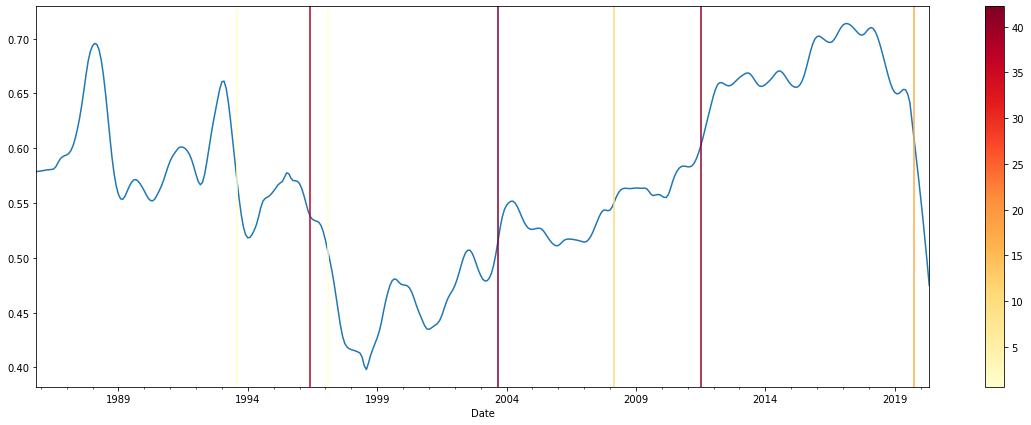

In [ ]:
def one_site_display(site_id):
  detector = cpDetector([trend_df[site_id]], distribution='log_normal', log_odds_threshold=0)
  detector.detect_cp()
  display(detector.change_points['traj_0'])
  get_change_points_plot(trend_df[site_id], detector)

one_site_display('NWGF')

17:24:10 INFO cpDetector: =======================================
17:24:10 INFO cpDetector: Running change point detector
17:24:10 INFO cpDetector: =======================================
17:24:10 INFO cpDetector:    input observations: 1 of length [410]
17:24:10 INFO cpDetector: Running cp detector on traj 0
17:24:10 INFO cpDetector: ---------------------------------
17:24:10 INFO cpDetector:     Found a new change point at: 312!!
17:24:11 INFO cpDetector:     Found a new change point at: 127!!
17:24:11 INFO cpDetector:     Found a new change point at: 93!!
17:24:12 INFO cpDetector:     Found a new change point at: 214!!
17:24:12 INFO cpDetector:     Found a new change point at: 135!!
17:24:12 INFO cpDetector:     Found a new change point at: 268!!
17:24:12 INFO cpDetector:     Found a new change point at: 296!!
17:24:13 INFO cpDetector:     Found a new change point at: 357!!
17:24:13 INFO cpDetector:     Found a new change point at: 394!!
17:24:13 INFO cpDetector: Generating step fuc

,ts,log_odds,start_end,prob_ts,date,pos_prob,no_days
0,312,58.096522,"(0, 410)","[1.9365485811734516e-87, 7.732441331760962e-86...",2011-11-30 00:00:00,86.9131,410
1,127,33.283103,"(0, 312)","[1.7119369237856425e-35, 6.837882458667255e-34...",1996-06-30 00:00:00,86.7133,312
2,93,0.635649,"(0, 127)","[5.879636979108912e-10, 1.1367879127821926e-08...",1993-08-31 00:00:00,93.1069,127
3,214,40.771997,"(127, 312)","[1.5355556918508462e-41, 1.551000609782402e-40...",2003-09-30 00:00:00,99.4006,185
4,135,0.509370,"(127, 214)","[1.0940345365886228e-06, 5.2901438229238603e-0...",1997-02-28 00:00:00,95.4046,87
5,268,12.934356,"(214, 312)","[1.036525004691065e-23, 6.029312705300334e-24,...",2008-03-31 00:00:00,100,98
6,296,3.985529,"(268, 312)","[7.005149142427668e-17, 8.875838158199869e-17,...",2010-07-31 00:00:00,92.9071,44
7,357,1.198981,"(312, 410)","[5.931725488388493e-19, 6.291271908591101e-19,...",2015-08-31 00:00:00,73.9261,98
8,394,0.611863,"(357, 410)","[1.11704915428727e-18, 7.196875600477855e-19, ...",2018-09-30 00:00:00,55.4446,53


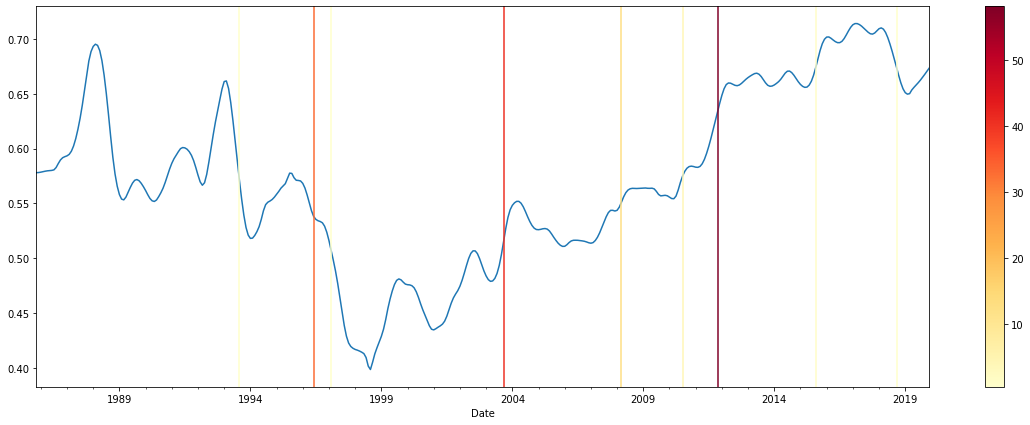

In [ ]:
get_casual_impact('NWGF')

# F2

06:11:16 INFO cpDetector: =======================================
06:11:16 INFO cpDetector: Running change point detector
06:11:16 INFO cpDetector: =======================================
06:11:16 INFO cpDetector:    input observations: 1 of length [415]
06:11:16 INFO cpDetector: Running cp detector on traj 0
06:11:16 INFO cpDetector: ---------------------------------
06:11:16 INFO cpDetector:     Found a new change point at: 111!!
06:11:17 INFO cpDetector:     Found a new change point at: 22!!
06:11:17 INFO cpDetector:     Found a new change point at: 213!!
06:11:18 INFO cpDetector:     Found a new change point at: 150!!
06:11:18 INFO cpDetector:     Found a new change point at: 183!!
06:11:18 INFO cpDetector: Generating step fucntion
06:11:18 INFO cpDetector: ---------------------------------
06:11:18 INFO cpDetector: Elapsed time: 2.732755661010742


,ts,log_odds,start_end,prob_ts
0,111,87.438899,"(0, 415)","[4.533946339182183e-86, 5.30362973702534e-85, ..."
1,22,5.083467,"(0, 111)","[2.631861188569156e-17, 6.100997395460235e-17,..."
2,213,5.575298,"(111, 415)","[3.809565623367043e-22, 3.280546406677319e-22,..."
3,150,3.184051,"(111, 213)","[4.839953480583665e-16, 2.476128950358513e-16,..."
4,183,3.139471,"(150, 213)","[5.934863303962019e-20, 5.432128964040654e-20,..."


Date
1985-11-30    0.339906
1985-12-31    0.336196
1986-01-31    0.332299
1986-02-28    0.328078
1986-03-31    0.323387
                ...   
2020-01-31    0.552896
2020-02-29    0.561932
2020-03-31    0.570828
2020-04-30    0.579520
2020-05-31    0.587892
Name: F2, Length: 415, dtype: float64

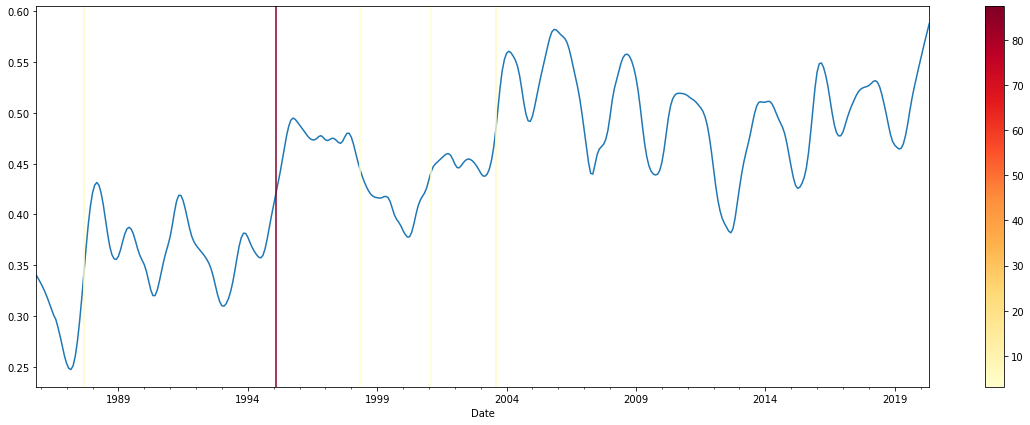

In [ ]:
one_site_display('F2')

17:29:37 INFO cpDetector: =======================================
17:29:37 INFO cpDetector: Running change point detector
17:29:37 INFO cpDetector: =======================================
17:29:37 INFO cpDetector:    input observations: 1 of length [410]
17:29:37 INFO cpDetector: Running cp detector on traj 0
17:29:37 INFO cpDetector: ---------------------------------
17:29:37 INFO cpDetector:     Found a new change point at: 111!!
17:29:38 INFO cpDetector:     Found a new change point at: 22!!
17:29:38 INFO cpDetector:     Found a new change point at: 213!!
17:29:39 INFO cpDetector:     Found a new change point at: 150!!
17:29:39 INFO cpDetector:     Found a new change point at: 183!!
17:29:39 INFO cpDetector:     Found a new change point at: 253!!
17:29:40 INFO cpDetector: Generating step fucntion
17:29:40 INFO cpDetector: ---------------------------------
17:29:40 INFO cpDetector: Elapsed time: 3.119764804840088


,ts,log_odds,start_end,prob_ts,date,pos_prob,no_days
0,111,88.030903,"(0, 410)","[3.3597577987070636e-86, 3.8554156956773665e-8...",1995-02-28 00:00:00,85.5145,410
1,22,5.208902,"(0, 111)","[2.1100041688319643e-17, 4.898378740054277e-17...",1987-09-30 00:00:00,93.8062,111
2,213,4.926510,"(111, 410)","[9.004300516584448e-21, 7.459459017562475e-21,...",2003-08-31 00:00:00,54.6454,299
3,150,3.149549,"(111, 213)","[4.355253563130924e-16, 2.2193022871890133e-16...",1998-05-31 00:00:00,78.6214,102
4,183,3.064178,"(150, 213)","[5.49967578536175e-20, 4.9952229773578115e-20,...",2001-02-28 00:00:00,73.7263,63
5,253,0.973851,"(213, 410)","[2.9199919271369123e-13, 2.319392669187675e-13...",2006-12-31 00:00:00,60.1399,197


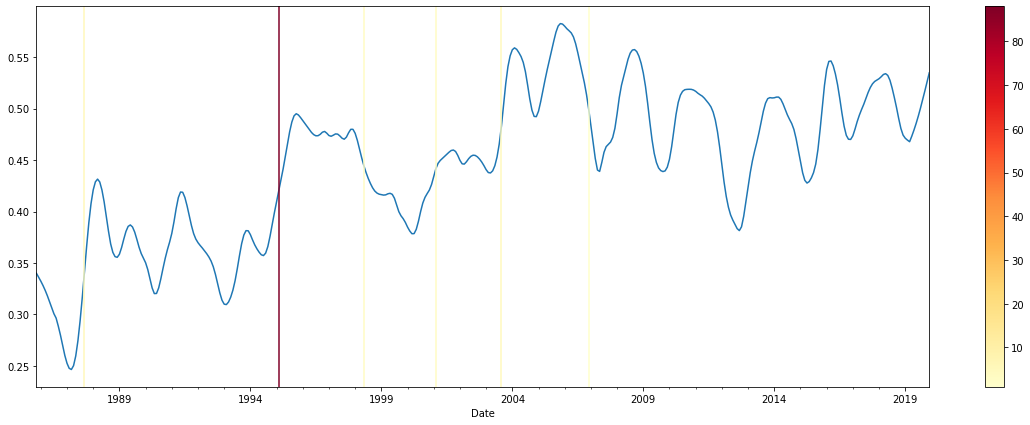

In [ ]:
get_casual_impact('F2')

looks decent

# MON2

06:11:37 INFO cpDetector: =======================================
06:11:37 INFO cpDetector: Running change point detector
06:11:37 INFO cpDetector: =======================================
06:11:37 INFO cpDetector:    input observations: 1 of length [415]
06:11:37 INFO cpDetector: Running cp detector on traj 0
06:11:37 INFO cpDetector: ---------------------------------
06:11:38 INFO cpDetector:     Found a new change point at: 137!!
06:11:39 INFO cpDetector:     Found a new change point at: 296!!
06:11:39 INFO cpDetector: Generating step fucntion
06:11:39 INFO cpDetector: ---------------------------------
06:11:39 INFO cpDetector: Elapsed time: 2.137866497039795


,ts,log_odds,start_end,prob_ts
0,137,89.480869,"(0, 415)","[1.1238884096896466e-80, 2.1778585216780006e-7..."
1,296,11.591745,"(137, 415)","[4.0272195925676456e-26, 2.0921195827596684e-2..."


Date
1985-11-30    0.588727
1985-12-31    0.590316
1986-01-31    0.591519
1986-02-28    0.592293
1986-03-31    0.592632
                ...   
2020-01-31    0.693761
2020-02-29    0.688748
2020-03-31    0.683529
2020-04-30    0.678127
2020-05-31    0.672513
Name: MON2, Length: 415, dtype: float64

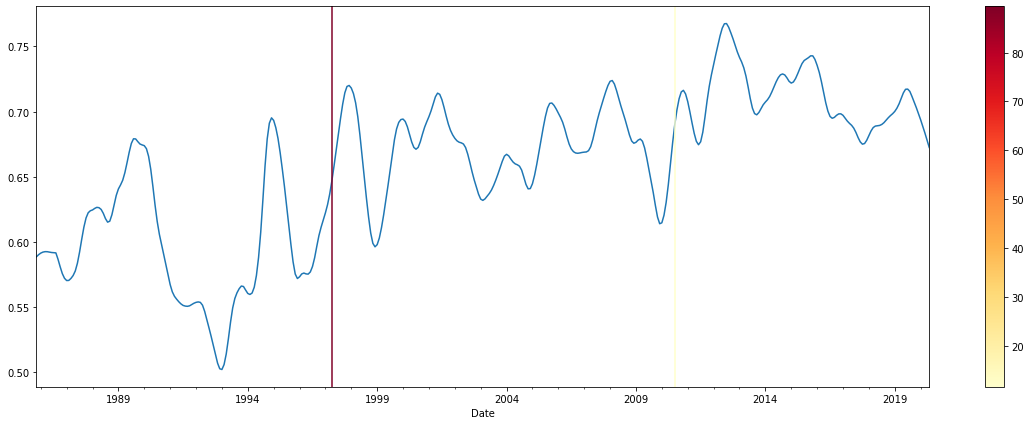

In [ ]:
one_site_display('MON2')

17:32:41 INFO cpDetector: =======================================
17:32:41 INFO cpDetector: Running change point detector
17:32:41 INFO cpDetector: =======================================
17:32:41 INFO cpDetector:    input observations: 1 of length [410]
17:32:41 INFO cpDetector: Running cp detector on traj 0
17:32:41 INFO cpDetector: ---------------------------------
17:32:42 INFO cpDetector:     Found a new change point at: 137!!
17:32:43 INFO cpDetector:     Found a new change point at: 296!!
17:32:44 INFO cpDetector: Generating step fucntion
17:32:44 INFO cpDetector: ---------------------------------
17:32:44 INFO cpDetector: Elapsed time: 2.1584482192993164


,ts,log_odds,start_end,prob_ts,date,pos_prob,no_days
0,137,87.538599,"(0, 410)","[9.802159331948756e-80, 1.8843783981888585e-78...",1997-04-30 00:00:00,80.9191,410
1,296,11.746137,"(137, 410)","[3.769048760442056e-27, 2.0058133070180654e-27...",2010-07-31 00:00:00,57.043,273


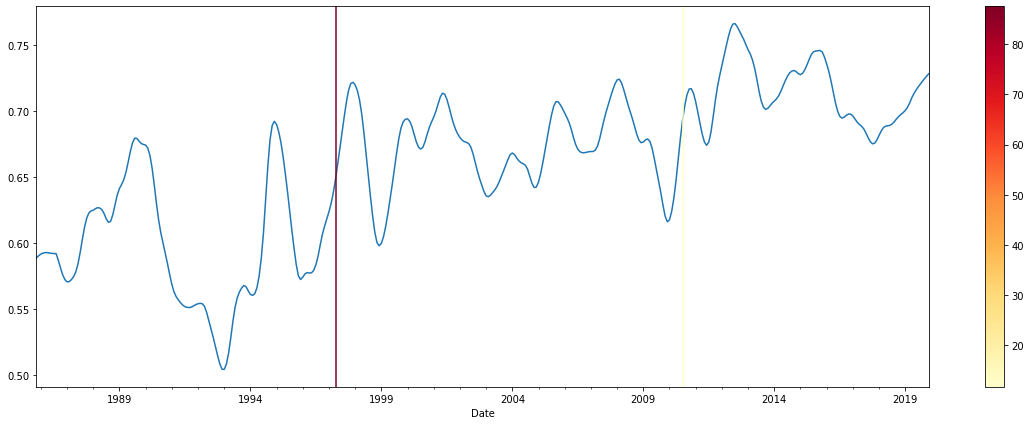

In [ ]:
get_casual_impact('MON2')

# MWSC

06:11:45 INFO cpDetector: =======================================
06:11:46 INFO cpDetector: Running change point detector
06:11:46 INFO cpDetector: =======================================
06:11:46 INFO cpDetector:    input observations: 1 of length [415]
06:11:46 INFO cpDetector: Running cp detector on traj 0
06:11:46 INFO cpDetector: ---------------------------------
06:11:46 INFO cpDetector:     Found a new change point at: 175!!
06:11:47 INFO cpDetector: Generating step fucntion
06:11:47 INFO cpDetector: ---------------------------------
06:11:47 INFO cpDetector: Elapsed time: 1.6195547580718994


,ts,log_odds,start_end,prob_ts
0,175,27.963577,"(0, 415)","[3.325413684267185e-28, 2.966237054528646e-26,..."


Date
1985-11-30    0.846259
1985-12-31    0.828619
1986-01-31    0.811526
1986-02-28    0.795079
1986-03-31    0.779329
                ...   
2020-01-31    0.650230
2020-02-29    0.654507
2020-03-31    0.658712
2020-04-30    0.662781
2020-05-31    0.666668
Name: MWSC, Length: 415, dtype: float64

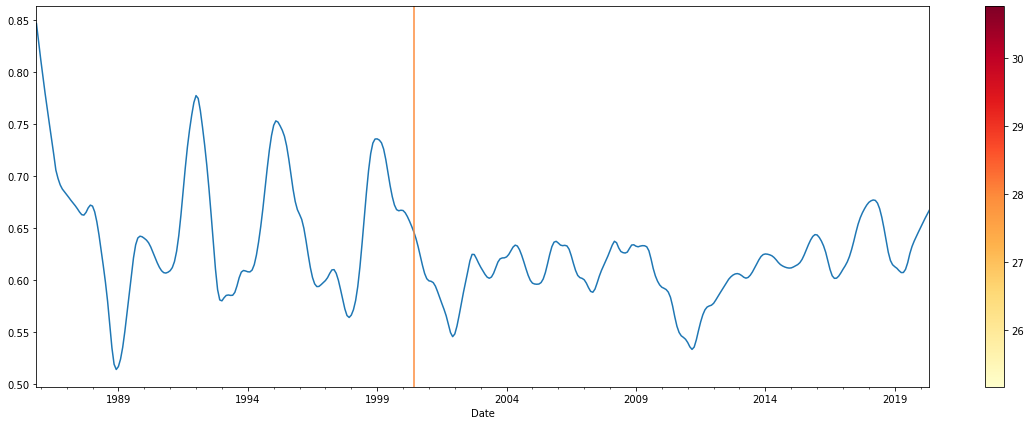

In [ ]:
one_site_display('MWSC')

08:25:49 INFO cpDetector: =======================================
08:25:49 INFO cpDetector: Running change point detector
08:25:49 INFO cpDetector: =======================================
08:25:49 INFO cpDetector:    input observations: 1 of length [410]
08:25:49 INFO cpDetector: Running cp detector on traj 0
08:25:49 INFO cpDetector: ---------------------------------
08:25:50 INFO cpDetector:     Found a new change point at: 175!!
08:25:50 INFO cpDetector: Generating step fucntion
08:25:50 INFO cpDetector: ---------------------------------
08:25:50 INFO cpDetector: Elapsed time: 1.666410207748413


,ts,log_odds,start_end,prob_ts,date,pos_prob,no_days
0,175,27.692441,"(0, 410)","[2.372139466890827e-28, 2.0032746203463288e-26...",2000-06-30 00:00:00,100,410


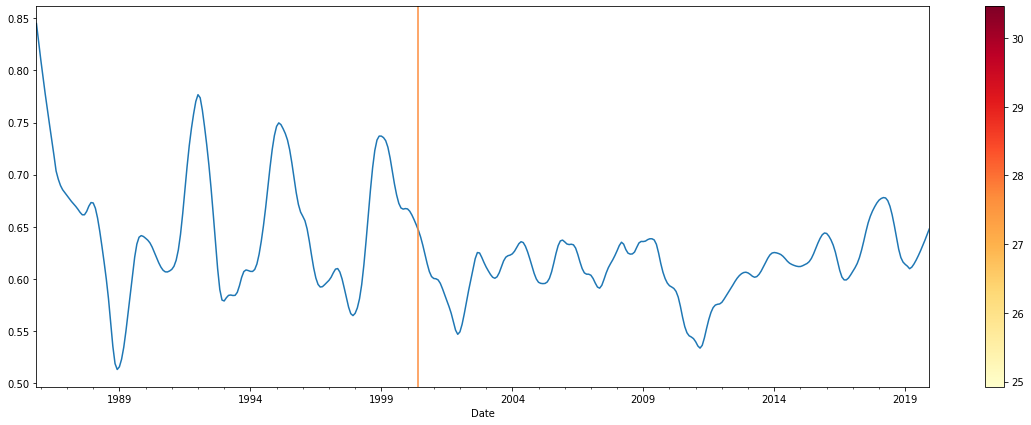

In [ ]:
get_casual_impact('MWSC')

seems to start at landsat7

# Clustering

In [ ]:
from DeepTemporalClustering.DeepTemporalClustering import DTC

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Clustering Variable Length Sequences by Eigenvector Decomposition Using HMM

https://arxiv.org/pdf/1811.12050.pdf

In [ ]:
# Z2